In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.utils import *
from torch_geometric.data import Data
import torch
import random
import numpy as np
random.seed()
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GNNExplainer
import networkx as nx
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Validation node label rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Number of validation nodes: 500
Validation node label rate: 0.18
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
data.to(device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
@torch.no_grad()
def Create_Samples(X, E, mask, p_1=0.5, p_2=0.5):
    '''
    Create a dataset for samples
    X: Node Features
    E: Edge Index
    mask: the mask token to be used
    p_1: the bernoulli prob. of masking for adjacency matrix
    p_2: the bernoulli prob. of masking for features
    '''
    # Number of Nodes
    V = X.size()[0] 
    # Number of Features
    F = X.size()[1]

    ## sampling random adjacency matrix
    #Original Adj Matrix
    A = to_dense_adj(E)
    #Prob of Keeping Adj Matrix
    P_adj = torch.rand(1,V,V).to(device)
    C = torch.mul(A,P_adj)
    #n stacks of Sample Adj Matrix
    Sample_Adj = C > p_1
    Sample_Adj,_ = dense_to_sparse(Sample_Adj)
    
    ## sampling random features
    P_feature = torch.rand(1,F).to(device)
    # Mask_feature = mask*torch.ones(1,F,dtype=torch.double).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    SF = torch.where(P_feature>(1-p_2),mask,X.float())
    Sample_Ft = SF
    
    return Sample_Ft, Sample_Adj

In [ ]:
@torch.no_grad()
def Create_Samples(X, E, mask, p_1=0.5, p_2=0.5):
    '''
    Create a dataset for samples
    X: Node Features
    E: Edge Index
    mask: the mask token to be used
    p_1: the bernoulli prob. of masking for adjacency matrix
    p_2: the bernoulli prob. of masking for features
    '''
    # Number of Nodes
    V = X.size()[0] 
    # Number of Features
    F = X.size()[1]

    ## sampling random adjacency matrix
    #Original Adj Matrix
    A = to_dense_adj(E)
    #Prob of Keeping Adj Matrix
    P_adj = torch.rand(1,V,V).to(device)
    C = torch.mul(A,P_adj)
    #n stacks of Sample Adj Matrix
    Sample_Adj = C > p_1
    Sample_Adj,_ = dense_to_sparse(Sample_Adj)
    
    ## sampling random features
    P_feature = torch.rand(1,F).to(device)
    # Mask_feature = mask*torch.ones(1,F,dtype=torch.double).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    # mask = mask.double()
    # print(mask)
    # prob = torch.as_tensor(1-p_2, dtype=torch.double).to(device)
    # prob = (1-p_2)*torch.ones(1,F,dtype=torch.double).to(device)
    SF = torch.where(P_feature>(1-p_2),mask,X.float())
    Sample_Ft = SF
    
    return Sample_Ft, Sample_Adj

In [6]:
from IPython.display import clear_output
@torch.no_grad()
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show()

In [7]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, mask=-0.1, p_1=0, p_2=0):
        super(Model, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        self.mask = False
        self.mask_param = [mask, p_1, p_2]

    def forward(self, x, edge_index):
        if self.mask == False:
            E = edge_index
            X = x
            self.mask = True
        else:
            X, E = Create_Samples(x, edge_index, self.mask_param[0], self.mask_param[1], self.mask_param[2])
        x = self.conv1(X, E)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, E)
        return x
    
    def change_param(self, mask, p_1, p_2):
        self.mask_param = [mask,p_1,p_2]

    def mask_off(self):
        self.mask = False

model = Model(hidden_channels=16)
print(model)

Model(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [8]:
@torch.no_grad()
def validate(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_loss, val_acc

@torch.no_grad()
def test(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


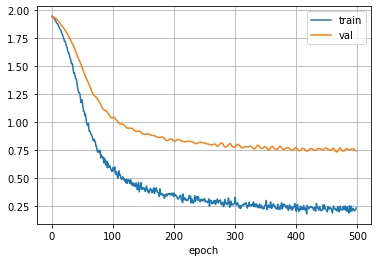

Val Accuracy: 0.7940


In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = Model(hidden_channels=16, mask = -0.01, p_1 = 0, p_2 = 0)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train(epoch):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

losses = {'train':[], 'val': []}

best_loss = 100
final_epoch = 0
max_epoch = 500
for epoch in range(1, max_epoch):
    loss = train(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_batch_losses = []
    train_batch_losses.append(loss.cpu())
    val_batch_losses = []
    val_loss, val_acc = validate(model)
    val_batch_losses.append(val_loss.cpu())
    
    if val_loss < best_loss:
        torch.save(model.state_dict(), './Models/Models_CORA/Full_Feature_1.pt')
        best_loss = val_loss
        final_epoch = epoch
        
    losses['train'].append(train_batch_losses)
    losses['val'].append(val_batch_losses)
    live_plot(losses)
    print(f'Val Accuracy: {val_acc:.4f}')

In [10]:
model = Model(hidden_channels=16, mask = -0.01, p_1 = 0, p_2 = 0)
model.load_state_dict(torch.load('./Models/Models_CORA/Full_Feature_1.pt'))
model.to(device)
model.change_param(-0.01,0,0)
_, val_acc = validate(model)
print('Validation:',val_acc)
test_acc = test(model)
print('Test:',test_acc)

Validation: 0.802
Test: 0.817


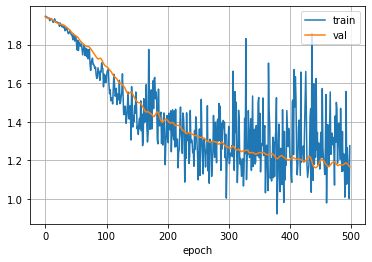

Val Accuracy: 0.7380
best model taken from epoch: 443


In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

eval_xg = Model(hidden_channels=16, mask = -0.01, p_1 = 0.5, p_2 = 0.5)
eval_xg.to(device)
optimizer = torch.optim.Adam(eval_xg.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train(epoch):
    eval_xg.train()
    optimizer.zero_grad()  # Clear gradients.
    out = eval_xg(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

losses = {'train':[], 'val': []}
max_epoch = 500

best_loss = 100
final_epoch = 0

for epoch in range(1, max_epoch):
    loss = train(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_batch_losses = []
    train_batch_losses.append(loss.cpu())
    val_batch_losses = []
    val_loss, val_acc = validate(eval_xg)
    val_batch_losses.append(val_loss.cpu())
    
    if epoch>(max_epoch-100) and val_loss < best_loss:
        torch.save(eval_xg.state_dict(), './Models/Models_CORA/eval_xg_1.pt')
        best_loss = val_loss
        final_epoch = epoch

    losses['train'].append(train_batch_losses)
    losses['val'].append(val_batch_losses)
    live_plot(losses)
    print(f'Val Accuracy: {val_acc:.4f}')
    print('best model taken from epoch:', final_epoch)

In [12]:
eval_xg = Model(hidden_channels=16, mask = -0.01, p_1 = 0, p_2 = 0)
eval_xg.load_state_dict(torch.load('./Models/Models_CORA/eval_xg_1.pt'))
eval_xg.to(device)
eval_xg.change_param(-0.01,0,0)
_, val_acc = validate(eval_xg)
print('Validation:',val_acc)
test_acc = test(eval_xg)
print('Test:',test_acc)

Validation: 0.75
Test: 0.783


In [13]:
@torch.no_grad()
def Explain_Samples(X,E,mask,node_feat_mask,edge_mask,num_feat,num_edge):
    '''
    Create a data samples given the explanation
    This function will only retain features and edges indicated as important from the dataset
    X: Node Features
    E: Edge Index
    mask: Mask Token to mask features
    node_feat_mask: Node Feature Mask returned by GNNExplainer
    edge_mask: Edge Mask returned by GNNExplainer
    num_feat: Number of Top Features to include in Data
    num_edge: Number of Top Edges to include in Data
    '''
    ## Get the top num_edge important edges
    n = edge_mask.size()[0]
    imp_e_indexes = torch.zeros(num_edge,)
    for i in range(num_edge):
        e_index = torch.argmax(edge_mask)
        edge_mask[e_index] = -1
        imp_e_indexes[i,] = e_index
    imp_e_indexes = imp_e_indexes.type(torch.LongTensor)
    Sample_Adj = E[:, imp_e_indexes]
    
    f = X.size()[1]
    imp_f_indexes = torch.zeros(num_feat,)
    for i in range(num_feat):
        f_index = torch.argmax(node_feat_mask)
        node_feat_mask[f_index] = -1
        imp_f_indexes[i,] = f_index
    imp_f_indexes = imp_f_indexes.type(torch.LongTensor)
    imp_f = torch.zeros(f,)
    imp_f[imp_f_indexes] = 1
    imp_f = imp_f.type(torch.LongTensor).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    Sample_Ft = torch.where(imp_f == 1, data.x.float(), mask)
  
    return Sample_Ft, Sample_Adj

Explain node 0: 100%|██████████| 200/200 [00:01<00:00, 183.55it/s]


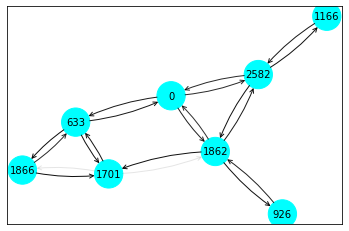

======NODE FEATURES=======
The important indexes:
 tensor([[   0],
        [   1],
        [   2],
        ...,
        [1430],
        [1431],
        [1432]], device='cuda:0')
The number of important features:
 tensor(1433, device='cuda:0')
The Nonzero Values in node feat mask:
 tensor([[0.1360],
        [0.1374],
        [0.1579],
        ...,
        [0.1492],
        [0.1335],
        [0.1324]], device='cuda:0')



======EDGES========
The important indexes:
 tensor([[    0],
        [    1],
        [    2],
        [ 2569],
        [ 2570],
        [ 2571],
        [ 3637],
        [ 4551],
        [ 6751],
        [ 6787],
        [ 6791],
        [ 7565],
        [ 7566],
        [ 7567],
        [ 7568],
        [ 7578],
        [ 7579],
        [10306],
        [10307],
        [10308]], device='cuda:0')
Corresponding actual edges:
 tensor([[[   0],
         [   0],
         [   0],
         [ 633],
         [ 633],
         [ 633],
         [ 926],
         [1166],
         

In [14]:
### TO CHECK WHETHER OUR FUNCTION Explain_Samples is working
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
explainer.to(device)
node_idx = 0
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()

## FOR NODE FEATURES
f = node_feat_mask>0.1
print("======NODE FEATURES=======")
print('The important indexes:\n',(f == 1).nonzero())
print('The number of important features:\n',f.sum())
f2 = torch.mul(node_feat_mask,f)
f2 = f2[f2.nonzero()]
print('The Nonzero Values in node feat mask:\n',f2)

print('\n\n')

## FOR EDGES
print("======EDGES========")
e = edge_mask > 0.05
print('The important indexes:\n',(e == 1).nonzero())
print('Corresponding actual edges:\n', data.edge_index[:,(e == 1).nonzero()])
print('The number of important edges:\n',e.sum())
e2 = torch.mul(edge_mask,e)
e2 = e2[e2.nonzero()]
print('The Nonzero Values in edge mask:\n',e2)
print(data.edge_index)

In [15]:
SF,SA = Explain_Samples(data.x,data.edge_index,-0.01,node_feat_mask,edge_mask,100,10)
print(SF)
print(SA)

tensor([[-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100],
        ...,
        [-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100,  0.0000,  ..., -0.0100, -0.0100, -0.0100]],
       device='cuda:0')
tensor([[ 633, 1866, 1862, 2582,  633, 1862, 2582, 1701,  633, 1166],
        [1866, 1701,  926, 1166, 1701, 1701, 1862,  633,    0, 2582]],
       device='cuda:0')


In [16]:
@torch.no_grad()
def forward_explain(model,Sample_Ft,Sample_Adj,node_idx):
    model.eval()
    model.mask_off()
    out = model(Sample_Ft,Sample_Adj)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = 0
    if pred[node_idx] == data.y[node_idx]:
        correct = 1
    return correct

Experiment 1: Run GNNExplainer on model (full feature), test its performance on model and Eval-XG

In [19]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
explainer.to(device)
model_total_correct = 0
eval_xg_total_correct = 0
count = 0
for i in range(data.num_nodes):
    if data.test_mask[i]==False:
        continue
    count+=1
    node_idx = i
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
    SF, SA = Explain_Samples(data.x,data.edge_index,-0.01,node_feat_mask,edge_mask,50,10)
    
    model_correct = forward_explain(model,SF,SA,node_idx)
    model_total_correct += model_correct
    
    eval_xg_correct = forward_explain(eval_xg,SF,SA,node_idx)
    eval_xg_total_correct += eval_xg_correct
    
    print("Accuracy on EVAL-XG: ", eval_xg_total_correct/count * 100)
    print("Accuracy on Model: ", model_total_correct/count * 100)
    
print("EVAL-XG Total Accuracy: ", eval_xg_total_correct/count * 100)   
print('Model Total Accuracy: ', model_total_correct/count * 100)



  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1708:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1708:   8%|▊         | 17/200 [00:00<00:01, 168.54it/s]

Explain node 1708:  17%|█▋        | 34/200 [00:00<00:01, 164.88it/s]

Explain node 1708:  26%|██▌       | 51/200 [00:00<00:00, 166.64it/s]

Explain node 1708:  34%|███▍      | 68/200 [00:00<00:00, 167.40it/s]

Explain node 1708:  42%|████▎     | 85/200 [00:00<00:00, 168.31it/s]

Explain node 1708:  52%|█████▏    | 103/200 [00:00<00:00, 169.52it/s]

Explain node 1708:  60%|██████    | 120/200 [00:00<00:00, 169.04it/s]

Explain node 1708:  68%|██████▊   | 137/200 [00:00<00:00, 168.91it/s]

Explain node 1708:  77%|███████▋  | 154/200 [00:00<00:00, 168.64it/s]

Explain node 1708:  86%|████████▌ | 171/200 [00:01<00:00, 168.57it/s]

Explain node 1708: 100%|██████████| 200/200 [00:01<00:00, 168.92it/s]


Accuracy on EVAL-XG:  0.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1709:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1709:   8%|▊         | 16/200 [00:00<00:01, 158.01it/s]

Explain node 1709:  16%|█▌        | 32/200 [00:00<00:01, 157.72it/s]

Explain node 1709:  24%|██▍       | 48/200 [00:00<00:00, 158.75it/s]

Explain node 1709:  32%|███▎      | 65/200 [00:00<00:00, 160.19it/s]

Explain node 1709:  41%|████      | 82/200 [00:00<00:00, 160.11it/s]

Explain node 1709:  50%|████▉     | 99/200 [00:00<00:00, 161.21it/s]

Explain node 1709:  58%|█████▊    | 116/200 [00:00<00:00, 161.51it/s]

Explain node 1709:  66%|██████▋   | 133/200 [00:00<00:00, 162.31it/s]

Explain node 1709:  75%|███████▌  | 150/200 [00:00<00:00, 163.36it/s]

Explain node 1709:  84%|████████▎ | 167/200 [00:01<00:00, 163.57it/s]

Explain node 1709: 100%|██████████| 200/200 [00:01<00:00, 162.00it/s]


Accuracy on EVAL-XG:  0.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1710:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1710:   8%|▊         | 17/200 [00:00<00:01, 163.68it/s]

Explain node 1710:  17%|█▋        | 34/200 [00:00<00:01, 163.88it/s]

Explain node 1710:  26%|██▌       | 51/200 [00:00<00:00, 164.66it/s]

Explain node 1710:  34%|███▍      | 68/200 [00:00<00:00, 163.33it/s]

Explain node 1710:  42%|████▎     | 85/200 [00:00<00:00, 163.91it/s]

Explain node 1710:  51%|█████     | 102/200 [00:00<00:00, 162.70it/s]

Explain node 1710:  60%|█████▉    | 119/200 [00:00<00:00, 163.01it/s]

Explain node 1710:  68%|██████▊   | 136/200 [00:00<00:00, 162.84it/s]

Explain node 1710:  76%|███████▋  | 153/200 [00:00<00:00, 163.73it/s]

Explain node 1710:  86%|████████▌ | 171/200 [00:01<00:00, 165.86it/s]

Explain node 1710: 100%|██████████| 200/200 [00:01<00:00, 164.60it/s]


Accuracy on EVAL-XG:  33.33333333333333
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1711:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1711:   9%|▉         | 18/200 [00:00<00:01, 172.37it/s]

Explain node 1711:  18%|█▊        | 36/200 [00:00<00:00, 166.97it/s]

Explain node 1711:  26%|██▋       | 53/200 [00:00<00:00, 166.72it/s]

Explain node 1711:  36%|███▌      | 71/200 [00:00<00:00, 168.13it/s]

Explain node 1711:  44%|████▍     | 88/200 [00:00<00:00, 168.58it/s]

Explain node 1711:  53%|█████▎    | 106/200 [00:00<00:00, 169.22it/s]

Explain node 1711:  62%|██████▏   | 123/200 [00:00<00:00, 168.48it/s]

Explain node 1711:  70%|███████   | 141/200 [00:00<00:00, 170.10it/s]

Explain node 1711:  80%|███████▉  | 159/200 [00:00<00:00, 169.27it/s]

Explain node 1711:  88%|████████▊ | 176/200 [00:01<00:00, 168.71it/s]

Explain node 1711: 100%|██████████| 200/200 [00:01<00:00, 167.79it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1712:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1712:   8%|▊         | 17/200 [00:00<00:01, 168.86it/s]

Explain node 1712:  17%|█▋        | 34/200 [00:00<00:01, 164.74it/s]

Explain node 1712:  26%|██▌       | 51/200 [00:00<00:00, 165.83it/s]

Explain node 1712:  34%|███▍      | 68/200 [00:00<00:00, 166.44it/s]

Explain node 1712:  42%|████▎     | 85/200 [00:00<00:00, 166.74it/s]

Explain node 1712:  51%|█████     | 102/200 [00:00<00:00, 166.97it/s]

Explain node 1712:  60%|█████▉    | 119/200 [00:00<00:00, 166.39it/s]

Explain node 1712:  68%|██████▊   | 136/200 [00:00<00:00, 167.36it/s]

Explain node 1712:  76%|███████▋  | 153/200 [00:00<00:00, 167.63it/s]

Explain node 1712:  85%|████████▌ | 170/200 [00:01<00:00, 167.72it/s]

Explain node 1712: 100%|██████████| 200/200 [00:01<00:00, 167.38it/s]


Accuracy on EVAL-XG:  20.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1713:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1713:   8%|▊         | 17/200 [00:00<00:01, 165.30it/s]

Explain node 1713:  17%|█▋        | 34/200 [00:00<00:00, 166.69it/s]

Explain node 1713:  26%|██▌       | 51/200 [00:00<00:00, 165.15it/s]

Explain node 1713:  34%|███▍      | 68/200 [00:00<00:00, 164.48it/s]

Explain node 1713:  42%|████▎     | 85/200 [00:00<00:00, 163.73it/s]

Explain node 1713:  51%|█████     | 102/200 [00:00<00:00, 164.38it/s]

Explain node 1713:  60%|█████▉    | 119/200 [00:00<00:00, 164.44it/s]

Explain node 1713:  68%|██████▊   | 136/200 [00:00<00:00, 164.42it/s]

Explain node 1713:  76%|███████▋  | 153/200 [00:00<00:00, 164.70it/s]

Explain node 1713:  86%|████████▌ | 171/200 [00:01<00:00, 166.10it/s]

Explain node 1713: 100%|██████████| 200/200 [00:01<00:00, 165.32it/s]


Accuracy on EVAL-XG:  16.666666666666664
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1714:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1714:   8%|▊         | 17/200 [00:00<00:01, 166.36it/s]

Explain node 1714:  17%|█▋        | 34/200 [00:00<00:01, 165.10it/s]

Explain node 1714:  26%|██▌       | 51/200 [00:00<00:00, 166.37it/s]

Explain node 1714:  34%|███▍      | 68/200 [00:00<00:00, 166.77it/s]

Explain node 1714:  43%|████▎     | 86/200 [00:00<00:00, 168.72it/s]

Explain node 1714:  52%|█████▏    | 104/200 [00:00<00:00, 170.34it/s]

Explain node 1714:  61%|██████    | 122/200 [00:00<00:00, 168.92it/s]

Explain node 1714:  70%|██████▉   | 139/200 [00:00<00:00, 168.08it/s]

Explain node 1714:  78%|███████▊  | 156/200 [00:00<00:00, 166.57it/s]

Explain node 1714:  86%|████████▋ | 173/200 [00:01<00:00, 166.10it/s]

Explain node 1714: 100%|██████████| 200/200 [00:01<00:00, 167.12it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1715:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1715:   8%|▊         | 17/200 [00:00<00:01, 169.05it/s]

Explain node 1715:  17%|█▋        | 34/200 [00:00<00:01, 165.40it/s]

Explain node 1715:  26%|██▌       | 51/200 [00:00<00:00, 166.70it/s]

Explain node 1715:  34%|███▍      | 69/200 [00:00<00:00, 169.15it/s]

Explain node 1715:  44%|████▎     | 87/200 [00:00<00:00, 169.66it/s]

Explain node 1715:  52%|█████▎    | 105/200 [00:00<00:00, 170.56it/s]

Explain node 1715:  62%|██████▏   | 123/200 [00:00<00:00, 170.50it/s]

Explain node 1715:  70%|███████   | 141/200 [00:00<00:00, 169.57it/s]

Explain node 1715:  79%|███████▉  | 158/200 [00:00<00:00, 168.33it/s]

Explain node 1715:  88%|████████▊ | 175/200 [00:01<00:00, 168.56it/s]

Explain node 1715: 100%|██████████| 200/200 [00:01<00:00, 168.80it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1716:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1716:   8%|▊         | 17/200 [00:00<00:01, 168.44it/s]

Explain node 1716:  18%|█▊        | 35/200 [00:00<00:00, 170.49it/s]

Explain node 1716:  26%|██▋       | 53/200 [00:00<00:00, 171.81it/s]

Explain node 1716:  36%|███▌      | 71/200 [00:00<00:00, 170.49it/s]

Explain node 1716:  44%|████▍     | 89/200 [00:00<00:00, 169.26it/s]

Explain node 1716:  53%|█████▎    | 106/200 [00:00<00:00, 168.20it/s]

Explain node 1716:  62%|██████▏   | 123/200 [00:00<00:00, 167.69it/s]

Explain node 1716:  70%|███████   | 141/200 [00:00<00:00, 168.60it/s]

Explain node 1716:  79%|███████▉  | 158/200 [00:00<00:00, 168.01it/s]

Explain node 1716:  88%|████████▊ | 176/200 [00:01<00:00, 168.78it/s]

Explain node 1716: 100%|██████████| 200/200 [00:01<00:00, 168.57it/s]


Accuracy on EVAL-XG:  22.22222222222222
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1717:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1717:   8%|▊         | 17/200 [00:00<00:01, 167.09it/s]

Explain node 1717:  17%|█▋        | 34/200 [00:00<00:00, 166.91it/s]

Explain node 1717:  26%|██▌       | 51/200 [00:00<00:00, 168.30it/s]

Explain node 1717:  34%|███▍      | 69/200 [00:00<00:00, 170.19it/s]

Explain node 1717:  44%|████▎     | 87/200 [00:00<00:00, 167.84it/s]

Explain node 1717:  52%|█████▏    | 104/200 [00:00<00:00, 165.64it/s]

Explain node 1717:  60%|██████    | 121/200 [00:00<00:00, 166.00it/s]

Explain node 1717:  69%|██████▉   | 138/200 [00:00<00:00, 165.55it/s]

Explain node 1717:  78%|███████▊  | 155/200 [00:00<00:00, 166.41it/s]

Explain node 1717:  86%|████████▋ | 173/200 [00:01<00:00, 167.65it/s]

Explain node 1717: 100%|██████████| 200/200 [00:01<00:00, 166.87it/s]


Accuracy on EVAL-XG:  20.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1718:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1718:   8%|▊         | 17/200 [00:00<00:01, 166.07it/s]

Explain node 1718:  17%|█▋        | 34/200 [00:00<00:00, 166.57it/s]

Explain node 1718:  26%|██▌       | 51/200 [00:00<00:00, 167.68it/s]

Explain node 1718:  34%|███▍      | 69/200 [00:00<00:00, 169.81it/s]

Explain node 1718:  43%|████▎     | 86/200 [00:00<00:00, 169.58it/s]

Explain node 1718:  52%|█████▏    | 103/200 [00:00<00:00, 169.58it/s]

Explain node 1718:  60%|██████    | 121/200 [00:00<00:00, 169.94it/s]

Explain node 1718:  69%|██████▉   | 138/200 [00:00<00:00, 168.57it/s]

Explain node 1718:  78%|███████▊  | 155/200 [00:00<00:00, 167.69it/s]

Explain node 1718:  86%|████████▌ | 172/200 [00:01<00:00, 166.70it/s]

Explain node 1718: 100%|██████████| 200/200 [00:01<00:00, 167.68it/s]


Accuracy on EVAL-XG:  27.27272727272727
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1719:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1719:   8%|▊         | 17/200 [00:00<00:01, 163.36it/s]

Explain node 1719:  17%|█▋        | 34/200 [00:00<00:00, 166.35it/s]

Explain node 1719:  26%|██▌       | 51/200 [00:00<00:00, 167.96it/s]

Explain node 1719:  34%|███▍      | 68/200 [00:00<00:00, 167.86it/s]

Explain node 1719:  42%|████▎     | 85/200 [00:00<00:00, 168.57it/s]

Explain node 1719:  51%|█████     | 102/200 [00:00<00:00, 167.68it/s]

Explain node 1719:  60%|█████▉    | 119/200 [00:00<00:00, 167.80it/s]

Explain node 1719:  68%|██████▊   | 137/200 [00:00<00:00, 169.26it/s]

Explain node 1719:  77%|███████▋  | 154/200 [00:00<00:00, 167.26it/s]

Explain node 1719:  86%|████████▌ | 171/200 [00:01<00:00, 167.50it/s]

Explain node 1719: 100%|██████████| 200/200 [00:01<00:00, 167.90it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1720:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1720:   9%|▉         | 18/200 [00:00<00:01, 175.20it/s]

Explain node 1720:  18%|█▊        | 36/200 [00:00<00:00, 168.92it/s]

Explain node 1720:  26%|██▋       | 53/200 [00:00<00:00, 166.03it/s]

Explain node 1720:  35%|███▌      | 70/200 [00:00<00:00, 166.24it/s]

Explain node 1720:  44%|████▍     | 88/200 [00:00<00:00, 168.31it/s]

Explain node 1720:  52%|█████▎    | 105/200 [00:00<00:00, 166.90it/s]

Explain node 1720:  61%|██████    | 122/200 [00:00<00:00, 167.38it/s]

Explain node 1720:  70%|███████   | 140/200 [00:00<00:00, 169.13it/s]

Explain node 1720:  78%|███████▊  | 157/200 [00:00<00:00, 167.84it/s]

Explain node 1720:  87%|████████▋ | 174/200 [00:01<00:00, 167.64it/s]

Explain node 1720: 100%|██████████| 200/200 [00:01<00:00, 167.87it/s]


Accuracy on EVAL-XG:  23.076923076923077
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1721:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1721:   8%|▊         | 17/200 [00:00<00:01, 165.85it/s]

Explain node 1721:  17%|█▋        | 34/200 [00:00<00:01, 165.26it/s]

Explain node 1721:  26%|██▌       | 51/200 [00:00<00:00, 165.51it/s]

Explain node 1721:  34%|███▍      | 69/200 [00:00<00:00, 168.82it/s]

Explain node 1721:  43%|████▎     | 86/200 [00:00<00:00, 167.16it/s]

Explain node 1721:  52%|█████▏    | 103/200 [00:00<00:00, 166.69it/s]

Explain node 1721:  60%|██████    | 120/200 [00:00<00:00, 166.48it/s]

Explain node 1721:  68%|██████▊   | 137/200 [00:00<00:00, 166.64it/s]

Explain node 1721:  77%|███████▋  | 154/200 [00:00<00:00, 167.29it/s]

Explain node 1721:  86%|████████▌ | 171/200 [00:01<00:00, 166.15it/s]

Explain node 1721: 100%|██████████| 200/200 [00:01<00:00, 167.24it/s]


Accuracy on EVAL-XG:  21.428571428571427
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1722:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1722:   8%|▊         | 17/200 [00:00<00:01, 164.75it/s]

Explain node 1722:  17%|█▋        | 34/200 [00:00<00:01, 165.90it/s]

Explain node 1722:  26%|██▌       | 51/200 [00:00<00:00, 167.48it/s]

Explain node 1722:  34%|███▍      | 68/200 [00:00<00:00, 168.12it/s]

Explain node 1722:  42%|████▎     | 85/200 [00:00<00:00, 167.88it/s]

Explain node 1722:  52%|█████▏    | 103/200 [00:00<00:00, 169.38it/s]

Explain node 1722:  60%|██████    | 121/200 [00:00<00:00, 169.78it/s]

Explain node 1722:  69%|██████▉   | 138/200 [00:00<00:00, 169.70it/s]

Explain node 1722:  78%|███████▊  | 156/200 [00:00<00:00, 171.29it/s]

Explain node 1722:  87%|████████▋ | 174/200 [00:01<00:00, 172.58it/s]

Explain node 1722: 100%|██████████| 200/200 [00:01<00:00, 169.48it/s]


Accuracy on EVAL-XG:  20.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1723:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1723:   8%|▊         | 17/200 [00:00<00:01, 162.52it/s]

Explain node 1723:  17%|█▋        | 34/200 [00:00<00:01, 163.02it/s]

Explain node 1723:  26%|██▌       | 51/200 [00:00<00:00, 163.80it/s]

Explain node 1723:  34%|███▍      | 69/200 [00:00<00:00, 166.54it/s]

Explain node 1723:  43%|████▎     | 86/200 [00:00<00:00, 167.23it/s]

Explain node 1723:  52%|█████▏    | 104/200 [00:00<00:00, 168.71it/s]

Explain node 1723:  60%|██████    | 121/200 [00:00<00:00, 168.98it/s]

Explain node 1723:  70%|██████▉   | 139/200 [00:00<00:00, 169.89it/s]

Explain node 1723:  78%|███████▊  | 156/200 [00:00<00:00, 169.57it/s]

Explain node 1723:  86%|████████▋ | 173/200 [00:01<00:00, 169.40it/s]

Explain node 1723: 100%|██████████| 200/200 [00:01<00:00, 168.60it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1724:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1724:   9%|▉         | 18/200 [00:00<00:01, 171.59it/s]

Explain node 1724:  18%|█▊        | 36/200 [00:00<00:00, 172.36it/s]

Explain node 1724:  27%|██▋       | 54/200 [00:00<00:00, 170.21it/s]

Explain node 1724:  36%|███▌      | 72/200 [00:00<00:00, 169.14it/s]

Explain node 1724:  45%|████▌     | 90/200 [00:00<00:00, 170.40it/s]

Explain node 1724:  54%|█████▍    | 108/200 [00:00<00:00, 170.43it/s]

Explain node 1724:  63%|██████▎   | 126/200 [00:00<00:00, 170.44it/s]

Explain node 1724:  72%|███████▏  | 144/200 [00:00<00:00, 169.27it/s]

Explain node 1724:  81%|████████  | 162/200 [00:00<00:00, 169.77it/s]

Explain node 1724:  90%|█████████ | 180/200 [00:01<00:00, 170.93it/s]

Explain node 1724: 100%|██████████| 200/200 [00:01<00:00, 170.34it/s]


Accuracy on EVAL-XG:  23.52941176470588
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1725:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1725:   8%|▊         | 17/200 [00:00<00:01, 166.37it/s]

Explain node 1725:  17%|█▋        | 34/200 [00:00<00:01, 164.78it/s]

Explain node 1725:  26%|██▌       | 51/200 [00:00<00:00, 164.93it/s]

Explain node 1725:  34%|███▍      | 68/200 [00:00<00:00, 166.02it/s]

Explain node 1725:  42%|████▎     | 85/200 [00:00<00:00, 165.36it/s]

Explain node 1725:  51%|█████     | 102/200 [00:00<00:00, 165.22it/s]

Explain node 1725:  60%|█████▉    | 119/200 [00:00<00:00, 164.95it/s]

Explain node 1725:  68%|██████▊   | 136/200 [00:00<00:00, 165.99it/s]

Explain node 1725:  76%|███████▋  | 153/200 [00:00<00:00, 165.77it/s]

Explain node 1725:  85%|████████▌ | 170/200 [00:01<00:00, 163.57it/s]

Explain node 1725: 100%|██████████| 200/200 [00:01<00:00, 164.13it/s]


Accuracy on EVAL-XG:  22.22222222222222
Accuracy on Model:  0.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1726:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1726:   8%|▊         | 17/200 [00:00<00:01, 165.02it/s]

Explain node 1726:  17%|█▋        | 34/200 [00:00<00:01, 149.97it/s]

Explain node 1726:  25%|██▌       | 50/200 [00:00<00:00, 152.82it/s]

Explain node 1726:  33%|███▎      | 66/200 [00:00<00:00, 154.18it/s]

Explain node 1726:  42%|████▏     | 83/200 [00:00<00:00, 158.07it/s]

Explain node 1726:  50%|█████     | 100/200 [00:00<00:00, 161.17it/s]

Explain node 1726:  58%|█████▊    | 117/200 [00:00<00:00, 163.66it/s]

Explain node 1726:  68%|██████▊   | 135/200 [00:00<00:00, 165.78it/s]

Explain node 1726:  76%|███████▌  | 152/200 [00:00<00:00, 165.57it/s]

Explain node 1726:  84%|████████▍ | 169/200 [00:01<00:00, 166.65it/s]

Explain node 1726: 100%|██████████| 200/200 [00:01<00:00, 163.02it/s]


Accuracy on EVAL-XG:  26.31578947368421
Accuracy on Model:  5.263157894736842




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1727:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1727:   9%|▉         | 18/200 [00:00<00:01, 171.65it/s]

Explain node 1727:  18%|█▊        | 36/200 [00:00<00:00, 169.86it/s]

Explain node 1727:  26%|██▋       | 53/200 [00:00<00:00, 169.26it/s]

Explain node 1727:  35%|███▌      | 70/200 [00:00<00:00, 169.40it/s]

Explain node 1727:  44%|████▎     | 87/200 [00:00<00:00, 168.82it/s]

Explain node 1727:  52%|█████▏    | 104/200 [00:00<00:00, 168.00it/s]

Explain node 1727:  61%|██████    | 122/200 [00:00<00:00, 170.56it/s]

Explain node 1727:  70%|███████   | 140/200 [00:00<00:00, 170.05it/s]

Explain node 1727:  79%|███████▉  | 158/200 [00:00<00:00, 170.85it/s]

Explain node 1727:  88%|████████▊ | 176/200 [00:01<00:00, 170.96it/s]

Explain node 1727: 100%|██████████| 200/200 [00:01<00:00, 169.69it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  5.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1728:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1728:   9%|▉         | 18/200 [00:00<00:01, 172.19it/s]

Explain node 1728:  18%|█▊        | 36/200 [00:00<00:00, 169.81it/s]

Explain node 1728:  26%|██▋       | 53/200 [00:00<00:00, 168.58it/s]

Explain node 1728:  35%|███▌      | 70/200 [00:00<00:00, 168.92it/s]

Explain node 1728:  44%|████▍     | 88/200 [00:00<00:00, 170.14it/s]

Explain node 1728:  53%|█████▎    | 106/200 [00:00<00:00, 169.79it/s]

Explain node 1728:  62%|██████▏   | 123/200 [00:00<00:00, 168.33it/s]

Explain node 1728:  70%|███████   | 140/200 [00:00<00:00, 167.25it/s]

Explain node 1728:  78%|███████▊  | 157/200 [00:00<00:00, 167.62it/s]

Explain node 1728:  87%|████████▋ | 174/200 [00:01<00:00, 167.68it/s]

Explain node 1728: 100%|██████████| 200/200 [00:01<00:00, 168.33it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  9.523809523809524




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1729:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1729:   8%|▊         | 17/200 [00:00<00:01, 168.75it/s]

Explain node 1729:  17%|█▋        | 34/200 [00:00<00:00, 166.09it/s]

Explain node 1729:  26%|██▌       | 51/200 [00:00<00:00, 165.17it/s]

Explain node 1729:  34%|███▍      | 68/200 [00:00<00:00, 165.31it/s]

Explain node 1729:  42%|████▎     | 85/200 [00:00<00:00, 165.52it/s]

Explain node 1729:  51%|█████     | 102/200 [00:00<00:00, 166.34it/s]

Explain node 1729:  60%|█████▉    | 119/200 [00:00<00:00, 165.71it/s]

Explain node 1729:  68%|██████▊   | 136/200 [00:00<00:00, 164.68it/s]

Explain node 1729:  76%|███████▋  | 153/200 [00:00<00:00, 165.83it/s]

Explain node 1729:  85%|████████▌ | 170/200 [00:01<00:00, 165.95it/s]

Explain node 1729: 100%|██████████| 200/200 [00:01<00:00, 165.61it/s]


Accuracy on EVAL-XG:  27.27272727272727
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1730:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1730:   9%|▉         | 18/200 [00:00<00:01, 170.86it/s]

Explain node 1730:  18%|█▊        | 36/200 [00:00<00:00, 169.19it/s]

Explain node 1730:  26%|██▋       | 53/200 [00:00<00:00, 169.50it/s]

Explain node 1730:  36%|███▌      | 71/200 [00:00<00:00, 170.93it/s]

Explain node 1730:  44%|████▍     | 89/200 [00:00<00:00, 169.15it/s]

Explain node 1730:  53%|█████▎    | 106/200 [00:00<00:00, 168.85it/s]

Explain node 1730:  62%|██████▏   | 124/200 [00:00<00:00, 170.24it/s]

Explain node 1730:  71%|███████   | 142/200 [00:00<00:00, 169.15it/s]

Explain node 1730:  80%|████████  | 160/200 [00:00<00:00, 170.55it/s]

Explain node 1730:  89%|████████▉ | 178/200 [00:01<00:00, 170.44it/s]

Explain node 1730: 100%|██████████| 200/200 [00:01<00:00, 169.38it/s]


Accuracy on EVAL-XG:  26.08695652173913
Accuracy on Model:  8.695652173913043




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1731:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1731:   8%|▊         | 17/200 [00:00<00:01, 165.61it/s]

Explain node 1731:  18%|█▊        | 35/200 [00:00<00:00, 169.03it/s]

Explain node 1731:  26%|██▋       | 53/200 [00:00<00:00, 170.58it/s]

Explain node 1731:  36%|███▌      | 71/200 [00:00<00:00, 167.25it/s]

Explain node 1731:  44%|████▍     | 88/200 [00:00<00:00, 165.30it/s]

Explain node 1731:  52%|█████▎    | 105/200 [00:00<00:00, 166.04it/s]

Explain node 1731:  61%|██████    | 122/200 [00:00<00:00, 166.16it/s]

Explain node 1731:  70%|██████▉   | 139/200 [00:00<00:00, 165.13it/s]

Explain node 1731:  78%|███████▊  | 156/200 [00:00<00:00, 166.43it/s]

Explain node 1731:  86%|████████▋ | 173/200 [00:01<00:00, 166.77it/s]

Explain node 1731: 100%|██████████| 200/200 [00:01<00:00, 167.01it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  8.333333333333332




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1732:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1732:   8%|▊         | 17/200 [00:00<00:01, 163.94it/s]

Explain node 1732:  17%|█▋        | 34/200 [00:00<00:01, 163.05it/s]

Explain node 1732:  26%|██▌       | 51/200 [00:00<00:00, 165.49it/s]

Explain node 1732:  34%|███▍      | 68/200 [00:00<00:00, 164.06it/s]

Explain node 1732:  42%|████▎     | 85/200 [00:00<00:00, 164.56it/s]

Explain node 1732:  51%|█████     | 102/200 [00:00<00:00, 165.03it/s]

Explain node 1732:  60%|█████▉    | 119/200 [00:00<00:00, 164.14it/s]

Explain node 1732:  68%|██████▊   | 136/200 [00:00<00:00, 164.43it/s]

Explain node 1732:  76%|███████▋  | 153/200 [00:00<00:00, 164.47it/s]

Explain node 1732:  85%|████████▌ | 170/200 [00:01<00:00, 164.26it/s]

Explain node 1732: 100%|██████████| 200/200 [00:01<00:00, 163.92it/s]


Accuracy on EVAL-XG:  28.000000000000004
Accuracy on Model:  8.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1733:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1733:   9%|▉         | 18/200 [00:00<00:01, 170.63it/s]

Explain node 1733:  18%|█▊        | 36/200 [00:00<00:00, 170.66it/s]

Explain node 1733:  27%|██▋       | 54/200 [00:00<00:00, 169.54it/s]

Explain node 1733:  36%|███▌      | 71/200 [00:00<00:00, 168.99it/s]

Explain node 1733:  44%|████▍     | 88/200 [00:00<00:00, 167.66it/s]

Explain node 1733:  52%|█████▎    | 105/200 [00:00<00:00, 167.10it/s]

Explain node 1733:  62%|██████▏   | 123/200 [00:00<00:00, 168.18it/s]

Explain node 1733:  70%|███████   | 140/200 [00:00<00:00, 167.20it/s]

Explain node 1733:  78%|███████▊  | 157/200 [00:00<00:00, 167.45it/s]

Explain node 1733:  87%|████████▋ | 174/200 [00:01<00:00, 166.74it/s]

Explain node 1733: 100%|██████████| 200/200 [00:01<00:00, 167.85it/s]


Accuracy on EVAL-XG:  26.923076923076923
Accuracy on Model:  7.6923076923076925




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1734:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1734:   8%|▊         | 17/200 [00:00<00:01, 164.94it/s]

Explain node 1734:  17%|█▋        | 34/200 [00:00<00:00, 166.62it/s]

Explain node 1734:  26%|██▌       | 51/200 [00:00<00:00, 164.69it/s]

Explain node 1734:  34%|███▍      | 68/200 [00:00<00:00, 165.19it/s]

Explain node 1734:  42%|████▎     | 85/200 [00:00<00:00, 166.05it/s]

Explain node 1734:  51%|█████     | 102/200 [00:00<00:00, 166.37it/s]

Explain node 1734:  60%|██████    | 120/200 [00:00<00:00, 168.18it/s]

Explain node 1734:  68%|██████▊   | 137/200 [00:00<00:00, 167.54it/s]

Explain node 1734:  77%|███████▋  | 154/200 [00:00<00:00, 167.76it/s]

Explain node 1734:  86%|████████▌ | 172/200 [00:01<00:00, 169.41it/s]

Explain node 1734: 100%|██████████| 200/200 [00:01<00:00, 167.40it/s]


Accuracy on EVAL-XG:  29.629629629629626
Accuracy on Model:  7.4074074074074066




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1735:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1735:   9%|▉         | 18/200 [00:00<00:01, 173.44it/s]

Explain node 1735:  18%|█▊        | 36/200 [00:00<00:00, 170.78it/s]

Explain node 1735:  27%|██▋       | 54/200 [00:00<00:00, 171.26it/s]

Explain node 1735:  36%|███▌      | 72/200 [00:00<00:00, 168.33it/s]

Explain node 1735:  44%|████▍     | 89/200 [00:00<00:00, 167.53it/s]

Explain node 1735:  53%|█████▎    | 106/200 [00:00<00:00, 167.54it/s]

Explain node 1735:  62%|██████▏   | 123/200 [00:00<00:00, 167.56it/s]

Explain node 1735:  70%|███████   | 140/200 [00:00<00:00, 167.98it/s]

Explain node 1735:  78%|███████▊  | 157/200 [00:00<00:00, 167.63it/s]

Explain node 1735:  87%|████████▋ | 174/200 [00:01<00:00, 167.72it/s]

Explain node 1735: 100%|██████████| 200/200 [00:01<00:00, 168.56it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  7.142857142857142




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1736:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1736:   8%|▊         | 17/200 [00:00<00:01, 169.20it/s]

Explain node 1736:  17%|█▋        | 34/200 [00:00<00:00, 168.56it/s]

Explain node 1736:  26%|██▌       | 51/200 [00:00<00:00, 165.38it/s]

Explain node 1736:  34%|███▍      | 68/200 [00:00<00:00, 165.49it/s]

Explain node 1736:  43%|████▎     | 86/200 [00:00<00:00, 169.46it/s]

Explain node 1736:  52%|█████▏    | 103/200 [00:00<00:00, 169.49it/s]

Explain node 1736:  60%|██████    | 120/200 [00:00<00:00, 169.63it/s]

Explain node 1736:  68%|██████▊   | 137/200 [00:00<00:00, 169.12it/s]

Explain node 1736:  77%|███████▋  | 154/200 [00:00<00:00, 169.06it/s]

Explain node 1736:  86%|████████▌ | 172/200 [00:01<00:00, 169.19it/s]

Explain node 1736: 100%|██████████| 200/200 [00:01<00:00, 167.89it/s]


Accuracy on EVAL-XG:  31.03448275862069
Accuracy on Model:  10.344827586206897




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1737:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1737:   8%|▊         | 17/200 [00:00<00:01, 165.58it/s]

Explain node 1737:  17%|█▋        | 34/200 [00:00<00:00, 167.44it/s]

Explain node 1737:  26%|██▌       | 51/200 [00:00<00:00, 166.79it/s]

Explain node 1737:  34%|███▍      | 68/200 [00:00<00:00, 167.71it/s]

Explain node 1737:  43%|████▎     | 86/200 [00:00<00:00, 169.29it/s]

Explain node 1737:  52%|█████▏    | 103/200 [00:00<00:00, 168.37it/s]

Explain node 1737:  60%|██████    | 120/200 [00:00<00:00, 168.49it/s]

Explain node 1737:  68%|██████▊   | 137/200 [00:00<00:00, 168.09it/s]

Explain node 1737:  77%|███████▋  | 154/200 [00:00<00:00, 168.05it/s]

Explain node 1737:  86%|████████▌ | 171/200 [00:01<00:00, 167.34it/s]

Explain node 1737: 100%|██████████| 200/200 [00:01<00:00, 167.41it/s]


Accuracy on EVAL-XG:  33.33333333333333
Accuracy on Model:  10.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1738:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1738:   8%|▊         | 17/200 [00:00<00:01, 168.77it/s]

Explain node 1738:  18%|█▊        | 35/200 [00:00<00:00, 169.85it/s]

Explain node 1738:  26%|██▌       | 52/200 [00:00<00:00, 169.65it/s]

Explain node 1738:  34%|███▍      | 69/200 [00:00<00:00, 168.83it/s]

Explain node 1738:  43%|████▎     | 86/200 [00:00<00:00, 168.11it/s]

Explain node 1738:  52%|█████▏    | 104/200 [00:00<00:00, 169.71it/s]

Explain node 1738:  60%|██████    | 121/200 [00:00<00:00, 168.74it/s]

Explain node 1738:  69%|██████▉   | 138/200 [00:00<00:00, 168.87it/s]

Explain node 1738:  78%|███████▊  | 155/200 [00:00<00:00, 168.84it/s]

Explain node 1738:  86%|████████▌ | 172/200 [00:01<00:00, 168.74it/s]

Explain node 1738: 100%|██████████| 200/200 [00:01<00:00, 168.84it/s]


Accuracy on EVAL-XG:  32.25806451612903
Accuracy on Model:  9.67741935483871




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1739:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1739:   8%|▊         | 17/200 [00:00<00:01, 167.04it/s]

Explain node 1739:  18%|█▊        | 35/200 [00:00<00:00, 169.88it/s]

Explain node 1739:  26%|██▌       | 52/200 [00:00<00:00, 167.49it/s]

Explain node 1739:  34%|███▍      | 69/200 [00:00<00:00, 166.70it/s]

Explain node 1739:  43%|████▎     | 86/200 [00:00<00:00, 165.92it/s]

Explain node 1739:  52%|█████▏    | 104/200 [00:00<00:00, 168.36it/s]

Explain node 1739:  60%|██████    | 121/200 [00:00<00:00, 168.21it/s]

Explain node 1739:  69%|██████▉   | 138/200 [00:00<00:00, 165.95it/s]

Explain node 1739:  78%|███████▊  | 155/200 [00:00<00:00, 165.92it/s]

Explain node 1739:  86%|████████▌ | 172/200 [00:01<00:00, 166.84it/s]

Explain node 1739: 100%|██████████| 200/200 [00:01<00:00, 167.01it/s]


Accuracy on EVAL-XG:  31.25
Accuracy on Model:  9.375




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1740:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1740:   8%|▊         | 17/200 [00:00<00:01, 164.81it/s]

Explain node 1740:  17%|█▋        | 34/200 [00:00<00:01, 165.34it/s]

Explain node 1740:  26%|██▌       | 51/200 [00:00<00:00, 164.39it/s]

Explain node 1740:  34%|███▍      | 68/200 [00:00<00:00, 164.48it/s]

Explain node 1740:  42%|████▎     | 85/200 [00:00<00:00, 165.17it/s]

Explain node 1740:  51%|█████     | 102/200 [00:00<00:00, 165.19it/s]

Explain node 1740:  60%|██████    | 120/200 [00:00<00:00, 167.03it/s]

Explain node 1740:  68%|██████▊   | 137/200 [00:00<00:00, 166.69it/s]

Explain node 1740:  77%|███████▋  | 154/200 [00:00<00:00, 165.65it/s]

Explain node 1740:  86%|████████▌ | 171/200 [00:01<00:00, 166.57it/s]

Explain node 1740: 100%|██████████| 200/200 [00:01<00:00, 166.46it/s]


Accuracy on EVAL-XG:  33.33333333333333
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1741:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1741:   9%|▉         | 18/200 [00:00<00:01, 170.91it/s]

Explain node 1741:  18%|█▊        | 36/200 [00:00<00:00, 168.60it/s]

Explain node 1741:  26%|██▋       | 53/200 [00:00<00:00, 168.06it/s]

Explain node 1741:  35%|███▌      | 70/200 [00:00<00:00, 167.16it/s]

Explain node 1741:  44%|████▎     | 87/200 [00:00<00:00, 166.33it/s]

Explain node 1741:  52%|█████▏    | 104/200 [00:00<00:00, 166.95it/s]

Explain node 1741:  60%|██████    | 121/200 [00:00<00:00, 166.38it/s]

Explain node 1741:  69%|██████▉   | 138/200 [00:00<00:00, 165.49it/s]

Explain node 1741:  78%|███████▊  | 155/200 [00:00<00:00, 164.88it/s]

Explain node 1741:  86%|████████▌ | 172/200 [00:01<00:00, 165.10it/s]

Explain node 1741: 100%|██████████| 200/200 [00:01<00:00, 166.11it/s]


Accuracy on EVAL-XG:  32.35294117647059
Accuracy on Model:  11.76470588235294




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1742:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1742:   8%|▊         | 17/200 [00:00<00:01, 165.33it/s]

Explain node 1742:  17%|█▋        | 34/200 [00:00<00:01, 165.03it/s]

Explain node 1742:  26%|██▌       | 52/200 [00:00<00:00, 167.82it/s]

Explain node 1742:  35%|███▌      | 70/200 [00:00<00:00, 170.01it/s]

Explain node 1742:  44%|████▎     | 87/200 [00:00<00:00, 167.76it/s]

Explain node 1742:  52%|█████▏    | 104/200 [00:00<00:00, 166.79it/s]

Explain node 1742:  60%|██████    | 121/200 [00:00<00:00, 166.15it/s]

Explain node 1742:  69%|██████▉   | 138/200 [00:00<00:00, 166.20it/s]

Explain node 1742:  78%|███████▊  | 155/200 [00:00<00:00, 166.72it/s]

Explain node 1742:  86%|████████▌ | 172/200 [00:01<00:00, 166.84it/s]

Explain node 1742: 100%|██████████| 200/200 [00:01<00:00, 166.23it/s]


Accuracy on EVAL-XG:  34.285714285714285
Accuracy on Model:  11.428571428571429




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1743:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1743:   8%|▊         | 17/200 [00:00<00:01, 168.06it/s]

Explain node 1743:  17%|█▋        | 34/200 [00:00<00:00, 169.11it/s]

Explain node 1743:  26%|██▌       | 51/200 [00:00<00:00, 168.19it/s]

Explain node 1743:  34%|███▍      | 69/200 [00:00<00:00, 169.60it/s]

Explain node 1743:  43%|████▎     | 86/200 [00:00<00:00, 167.02it/s]

Explain node 1743:  52%|█████▏    | 103/200 [00:00<00:00, 165.62it/s]

Explain node 1743:  60%|██████    | 120/200 [00:00<00:00, 163.52it/s]

Explain node 1743:  68%|██████▊   | 137/200 [00:00<00:00, 164.10it/s]

Explain node 1743:  77%|███████▋  | 154/200 [00:00<00:00, 165.50it/s]

Explain node 1743:  86%|████████▌ | 172/200 [00:01<00:00, 167.22it/s]

Explain node 1743: 100%|██████████| 200/200 [00:01<00:00, 166.66it/s]


Accuracy on EVAL-XG:  33.33333333333333
Accuracy on Model:  11.11111111111111




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1744:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1744:   9%|▉         | 18/200 [00:00<00:01, 170.28it/s]

Explain node 1744:  18%|█▊        | 36/200 [00:00<00:00, 169.94it/s]

Explain node 1744:  26%|██▋       | 53/200 [00:00<00:00, 168.27it/s]

Explain node 1744:  36%|███▌      | 71/200 [00:00<00:00, 170.17it/s]

Explain node 1744:  44%|████▍     | 89/200 [00:00<00:00, 171.82it/s]

Explain node 1744:  54%|█████▎    | 107/200 [00:00<00:00, 172.37it/s]

Explain node 1744:  62%|██████▎   | 125/200 [00:00<00:00, 171.74it/s]

Explain node 1744:  72%|███████▏  | 143/200 [00:00<00:00, 171.83it/s]

Explain node 1744:  80%|████████  | 161/200 [00:00<00:00, 169.84it/s]

Explain node 1744:  89%|████████▉ | 178/200 [00:01<00:00, 169.06it/s]

Explain node 1744: 100%|██████████| 200/200 [00:01<00:00, 169.83it/s]


Accuracy on EVAL-XG:  35.13513513513514
Accuracy on Model:  10.81081081081081




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1745:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1745:   9%|▉         | 18/200 [00:00<00:01, 175.80it/s]

Explain node 1745:  18%|█▊        | 36/200 [00:00<00:00, 173.06it/s]

Explain node 1745:  27%|██▋       | 54/200 [00:00<00:00, 168.65it/s]

Explain node 1745:  36%|███▌      | 71/200 [00:00<00:00, 167.36it/s]

Explain node 1745:  44%|████▍     | 89/200 [00:00<00:00, 168.69it/s]

Explain node 1745:  53%|█████▎    | 106/200 [00:00<00:00, 168.71it/s]

Explain node 1745:  62%|██████▏   | 124/200 [00:00<00:00, 169.32it/s]

Explain node 1745:  71%|███████   | 142/200 [00:00<00:00, 170.58it/s]

Explain node 1745:  80%|████████  | 161/200 [00:00<00:00, 175.06it/s]

Explain node 1745:  90%|█████████ | 180/200 [00:01<00:00, 179.45it/s]

Explain node 1745: 100%|██████████| 200/200 [00:01<00:00, 174.04it/s]


Accuracy on EVAL-XG:  34.21052631578947
Accuracy on Model:  10.526315789473683




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1746:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1746:   8%|▊         | 17/200 [00:00<00:01, 169.88it/s]

Explain node 1746:  17%|█▋        | 34/200 [00:00<00:00, 169.62it/s]

Explain node 1746:  26%|██▌       | 51/200 [00:00<00:00, 169.50it/s]

Explain node 1746:  34%|███▍      | 69/200 [00:00<00:00, 170.37it/s]

Explain node 1746:  44%|████▎     | 87/200 [00:00<00:00, 170.00it/s]

Explain node 1746:  52%|█████▏    | 104/200 [00:00<00:00, 169.93it/s]

Explain node 1746:  61%|██████    | 122/200 [00:00<00:00, 170.67it/s]

Explain node 1746:  70%|███████   | 140/200 [00:00<00:00, 171.19it/s]

Explain node 1746:  79%|███████▉  | 158/200 [00:00<00:00, 171.91it/s]

Explain node 1746:  88%|████████▊ | 176/200 [00:01<00:00, 169.86it/s]

Explain node 1746: 100%|██████████| 200/200 [00:01<00:00, 170.05it/s]


Accuracy on EVAL-XG:  35.8974358974359
Accuracy on Model:  10.256410256410255




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1747:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1747:   8%|▊         | 17/200 [00:00<00:01, 166.16it/s]

Explain node 1747:  17%|█▋        | 34/200 [00:00<00:00, 166.37it/s]

Explain node 1747:  26%|██▌       | 52/200 [00:00<00:00, 170.42it/s]

Explain node 1747:  35%|███▌      | 70/200 [00:00<00:00, 171.01it/s]

Explain node 1747:  44%|████▍     | 88/200 [00:00<00:00, 170.95it/s]

Explain node 1747:  53%|█████▎    | 106/200 [00:00<00:00, 170.45it/s]

Explain node 1747:  62%|██████▏   | 124/200 [00:00<00:00, 172.51it/s]

Explain node 1747:  71%|███████   | 142/200 [00:00<00:00, 172.93it/s]

Explain node 1747:  80%|████████  | 160/200 [00:00<00:00, 170.76it/s]

Explain node 1747:  89%|████████▉ | 178/200 [00:01<00:00, 168.83it/s]

Explain node 1747: 100%|██████████| 200/200 [00:01<00:00, 169.58it/s]


Accuracy on EVAL-XG:  37.5
Accuracy on Model:  10.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1748:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1748:   8%|▊         | 17/200 [00:00<00:01, 165.06it/s]

Explain node 1748:  17%|█▋        | 34/200 [00:00<00:01, 165.75it/s]

Explain node 1748:  26%|██▌       | 51/200 [00:00<00:00, 166.63it/s]

Explain node 1748:  34%|███▍      | 68/200 [00:00<00:00, 167.65it/s]

Explain node 1748:  43%|████▎     | 86/200 [00:00<00:00, 168.55it/s]

Explain node 1748:  52%|█████▏    | 103/200 [00:00<00:00, 166.36it/s]

Explain node 1748:  60%|██████    | 120/200 [00:00<00:00, 167.29it/s]

Explain node 1748:  68%|██████▊   | 137/200 [00:00<00:00, 165.77it/s]

Explain node 1748:  77%|███████▋  | 154/200 [00:00<00:00, 165.67it/s]

Explain node 1748:  86%|████████▌ | 171/200 [00:01<00:00, 164.43it/s]

Explain node 1748: 100%|██████████| 200/200 [00:01<00:00, 166.43it/s]


Accuracy on EVAL-XG:  39.02439024390244
Accuracy on Model:  9.75609756097561




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1749:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1749:   8%|▊         | 17/200 [00:00<00:01, 166.97it/s]

Explain node 1749:  17%|█▋        | 34/200 [00:00<00:00, 166.33it/s]

Explain node 1749:  26%|██▌       | 52/200 [00:00<00:00, 168.06it/s]

Explain node 1749:  34%|███▍      | 69/200 [00:00<00:00, 167.10it/s]

Explain node 1749:  44%|████▎     | 87/200 [00:00<00:00, 168.42it/s]

Explain node 1749:  52%|█████▏    | 104/200 [00:00<00:00, 168.84it/s]

Explain node 1749:  60%|██████    | 121/200 [00:00<00:00, 168.40it/s]

Explain node 1749:  69%|██████▉   | 138/200 [00:00<00:00, 168.49it/s]

Explain node 1749:  78%|███████▊  | 155/200 [00:00<00:00, 168.42it/s]

Explain node 1749:  86%|████████▋ | 173/200 [00:01<00:00, 169.23it/s]

Explain node 1749: 100%|██████████| 200/200 [00:01<00:00, 168.38it/s]


Accuracy on EVAL-XG:  38.095238095238095
Accuracy on Model:  9.523809523809524




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1750:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1750:   9%|▉         | 18/200 [00:00<00:01, 171.52it/s]

Explain node 1750:  18%|█▊        | 36/200 [00:00<00:00, 170.77it/s]

Explain node 1750:  27%|██▋       | 54/200 [00:00<00:00, 170.79it/s]

Explain node 1750:  36%|███▌      | 72/200 [00:00<00:00, 171.45it/s]

Explain node 1750:  45%|████▌     | 90/200 [00:00<00:00, 169.68it/s]

Explain node 1750:  54%|█████▎    | 107/200 [00:00<00:00, 168.69it/s]

Explain node 1750:  62%|██████▎   | 125/200 [00:00<00:00, 169.14it/s]

Explain node 1750:  71%|███████   | 142/200 [00:00<00:00, 168.19it/s]

Explain node 1750:  80%|███████▉  | 159/200 [00:00<00:00, 168.61it/s]

Explain node 1750:  88%|████████▊ | 177/200 [00:01<00:00, 169.04it/s]

Explain node 1750: 100%|██████████| 200/200 [00:01<00:00, 169.41it/s]


Accuracy on EVAL-XG:  37.2093023255814
Accuracy on Model:  9.30232558139535




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1751:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1751:   8%|▊         | 17/200 [00:00<00:01, 169.03it/s]

Explain node 1751:  18%|█▊        | 35/200 [00:00<00:00, 172.59it/s]

Explain node 1751:  26%|██▋       | 53/200 [00:00<00:00, 172.80it/s]

Explain node 1751:  36%|███▌      | 71/200 [00:00<00:00, 170.38it/s]

Explain node 1751:  44%|████▍     | 89/200 [00:00<00:00, 168.41it/s]

Explain node 1751:  53%|█████▎    | 106/200 [00:00<00:00, 168.02it/s]

Explain node 1751:  62%|██████▏   | 123/200 [00:00<00:00, 166.69it/s]

Explain node 1751:  70%|███████   | 140/200 [00:00<00:00, 166.52it/s]

Explain node 1751:  78%|███████▊  | 157/200 [00:00<00:00, 167.14it/s]

Explain node 1751:  87%|████████▋ | 174/200 [00:01<00:00, 167.68it/s]

Explain node 1751: 100%|██████████| 200/200 [00:01<00:00, 168.71it/s]


Accuracy on EVAL-XG:  36.36363636363637
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1752:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1752:   8%|▊         | 17/200 [00:00<00:01, 168.88it/s]

Explain node 1752:  17%|█▋        | 34/200 [00:00<00:00, 169.32it/s]

Explain node 1752:  26%|██▌       | 52/200 [00:00<00:00, 173.38it/s]

Explain node 1752:  35%|███▌      | 70/200 [00:00<00:00, 171.38it/s]

Explain node 1752:  44%|████▍     | 88/200 [00:00<00:00, 172.36it/s]

Explain node 1752:  53%|█████▎    | 106/200 [00:00<00:00, 172.33it/s]

Explain node 1752:  62%|██████▏   | 124/200 [00:00<00:00, 171.62it/s]

Explain node 1752:  71%|███████   | 142/200 [00:00<00:00, 173.17it/s]

Explain node 1752:  80%|████████  | 160/200 [00:00<00:00, 172.43it/s]

Explain node 1752:  89%|████████▉ | 178/200 [00:01<00:00, 171.44it/s]

Explain node 1752: 100%|██████████| 200/200 [00:01<00:00, 171.48it/s]


Accuracy on EVAL-XG:  35.55555555555556
Accuracy on Model:  8.88888888888889




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1753:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1753:   8%|▊         | 17/200 [00:00<00:01, 168.36it/s]

Explain node 1753:  18%|█▊        | 35/200 [00:00<00:00, 170.33it/s]

Explain node 1753:  26%|██▋       | 53/200 [00:00<00:00, 168.76it/s]

Explain node 1753:  36%|███▌      | 71/200 [00:00<00:00, 169.64it/s]

Explain node 1753:  44%|████▍     | 89/200 [00:00<00:00, 169.95it/s]

Explain node 1753:  53%|█████▎    | 106/200 [00:00<00:00, 169.92it/s]

Explain node 1753:  62%|██████▏   | 124/200 [00:00<00:00, 172.01it/s]

Explain node 1753:  71%|███████   | 142/200 [00:00<00:00, 171.35it/s]

Explain node 1753:  80%|████████  | 160/200 [00:00<00:00, 169.98it/s]

Explain node 1753:  89%|████████▉ | 178/200 [00:01<00:00, 170.99it/s]

Explain node 1753: 100%|██████████| 200/200 [00:01<00:00, 170.54it/s]


Accuracy on EVAL-XG:  36.95652173913043
Accuracy on Model:  8.695652173913043




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1754:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1754:   9%|▉         | 18/200 [00:00<00:01, 171.39it/s]

Explain node 1754:  18%|█▊        | 36/200 [00:00<00:00, 168.27it/s]

Explain node 1754:  26%|██▋       | 53/200 [00:00<00:00, 166.81it/s]

Explain node 1754:  36%|███▌      | 71/200 [00:00<00:00, 168.41it/s]

Explain node 1754:  44%|████▍     | 88/200 [00:00<00:00, 168.79it/s]

Explain node 1754:  52%|█████▎    | 105/200 [00:00<00:00, 169.08it/s]

Explain node 1754:  62%|██████▏   | 123/200 [00:00<00:00, 169.55it/s]

Explain node 1754:  70%|███████   | 141/200 [00:00<00:00, 170.22it/s]

Explain node 1754:  80%|███████▉  | 159/200 [00:00<00:00, 169.52it/s]

Explain node 1754:  88%|████████▊ | 177/200 [00:01<00:00, 171.25it/s]

Explain node 1754: 100%|██████████| 200/200 [00:01<00:00, 169.04it/s]


Accuracy on EVAL-XG:  36.17021276595745
Accuracy on Model:  8.51063829787234




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1755:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1755:   9%|▉         | 18/200 [00:00<00:01, 174.71it/s]

Explain node 1755:  18%|█▊        | 36/200 [00:00<00:00, 171.22it/s]

Explain node 1755:  27%|██▋       | 54/200 [00:00<00:00, 170.09it/s]

Explain node 1755:  36%|███▌      | 72/200 [00:00<00:00, 171.83it/s]

Explain node 1755:  45%|████▌     | 90/200 [00:00<00:00, 170.61it/s]

Explain node 1755:  54%|█████▍    | 108/200 [00:00<00:00, 170.41it/s]

Explain node 1755:  63%|██████▎   | 126/200 [00:00<00:00, 169.18it/s]

Explain node 1755:  72%|███████▏  | 144/200 [00:00<00:00, 169.70it/s]

Explain node 1755:  80%|████████  | 161/200 [00:00<00:00, 169.30it/s]

Explain node 1755:  89%|████████▉ | 178/200 [00:01<00:00, 169.38it/s]

Explain node 1755: 100%|██████████| 200/200 [00:01<00:00, 170.10it/s]


Accuracy on EVAL-XG:  35.41666666666667
Accuracy on Model:  8.333333333333332




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1756:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1756:   8%|▊         | 17/200 [00:00<00:01, 168.18it/s]

Explain node 1756:  17%|█▋        | 34/200 [00:00<00:00, 168.15it/s]

Explain node 1756:  26%|██▌       | 51/200 [00:00<00:00, 168.43it/s]

Explain node 1756:  34%|███▍      | 68/200 [00:00<00:00, 168.46it/s]

Explain node 1756:  43%|████▎     | 86/200 [00:00<00:00, 170.11it/s]

Explain node 1756:  52%|█████▏    | 104/200 [00:00<00:00, 164.66it/s]

Explain node 1756:  60%|██████    | 121/200 [00:00<00:00, 165.81it/s]

Explain node 1756:  69%|██████▉   | 138/200 [00:00<00:00, 166.35it/s]

Explain node 1756:  78%|███████▊  | 155/200 [00:00<00:00, 166.62it/s]

Explain node 1756:  86%|████████▋ | 173/200 [00:01<00:00, 167.90it/s]

Explain node 1756: 100%|██████████| 200/200 [00:01<00:00, 166.56it/s]


Accuracy on EVAL-XG:  36.734693877551024
Accuracy on Model:  10.204081632653061




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1757:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1757:   8%|▊         | 16/200 [00:00<00:01, 158.38it/s]

Explain node 1757:  16%|█▋        | 33/200 [00:00<00:01, 162.31it/s]

Explain node 1757:  25%|██▌       | 50/200 [00:00<00:00, 163.23it/s]

Explain node 1757:  34%|███▎      | 67/200 [00:00<00:00, 163.90it/s]

Explain node 1757:  42%|████▏     | 84/200 [00:00<00:00, 164.79it/s]

Explain node 1757:  50%|█████     | 101/200 [00:00<00:00, 166.06it/s]

Explain node 1757:  60%|██████    | 120/200 [00:00<00:00, 171.54it/s]

Explain node 1757:  70%|██████▉   | 139/200 [00:00<00:00, 174.38it/s]

Explain node 1757:  79%|███████▉  | 158/200 [00:00<00:00, 176.49it/s]

Explain node 1757:  88%|████████▊ | 177/200 [00:01<00:00, 178.90it/s]

Explain node 1757: 100%|██████████| 200/200 [00:01<00:00, 172.26it/s]


Accuracy on EVAL-XG:  36.0
Accuracy on Model:  10.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1758:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1758:   8%|▊         | 17/200 [00:00<00:01, 166.06it/s]

Explain node 1758:  17%|█▋        | 34/200 [00:00<00:01, 165.65it/s]

Explain node 1758:  26%|██▌       | 51/200 [00:00<00:00, 162.66it/s]

Explain node 1758:  34%|███▍      | 68/200 [00:00<00:00, 162.58it/s]

Explain node 1758:  42%|████▎     | 85/200 [00:00<00:00, 164.09it/s]

Explain node 1758:  51%|█████     | 102/200 [00:00<00:00, 163.02it/s]

Explain node 1758:  60%|█████▉    | 119/200 [00:00<00:00, 163.66it/s]

Explain node 1758:  68%|██████▊   | 136/200 [00:00<00:00, 164.62it/s]

Explain node 1758:  76%|███████▋  | 153/200 [00:00<00:00, 164.69it/s]

Explain node 1758:  85%|████████▌ | 170/200 [00:01<00:00, 164.13it/s]

Explain node 1758: 100%|██████████| 200/200 [00:01<00:00, 164.51it/s]


Accuracy on EVAL-XG:  37.254901960784316
Accuracy on Model:  9.803921568627452




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1759:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1759:   8%|▊         | 17/200 [00:00<00:01, 169.87it/s]

Explain node 1759:  17%|█▋        | 34/200 [00:00<00:00, 169.63it/s]

Explain node 1759:  26%|██▌       | 51/200 [00:00<00:00, 168.87it/s]

Explain node 1759:  34%|███▍      | 68/200 [00:00<00:00, 167.26it/s]

Explain node 1759:  42%|████▎     | 85/200 [00:00<00:00, 166.71it/s]

Explain node 1759:  51%|█████     | 102/200 [00:00<00:00, 166.23it/s]

Explain node 1759:  60%|█████▉    | 119/200 [00:00<00:00, 166.59it/s]

Explain node 1759:  68%|██████▊   | 137/200 [00:00<00:00, 168.17it/s]

Explain node 1759:  77%|███████▋  | 154/200 [00:00<00:00, 167.79it/s]

Explain node 1759:  86%|████████▌ | 172/200 [00:01<00:00, 168.60it/s]

Explain node 1759: 100%|██████████| 200/200 [00:01<00:00, 167.40it/s]


Accuracy on EVAL-XG:  38.46153846153847
Accuracy on Model:  9.615384615384617




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1760:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1760:   9%|▉         | 18/200 [00:00<00:01, 175.09it/s]

Explain node 1760:  18%|█▊        | 36/200 [00:00<00:00, 167.99it/s]

Explain node 1760:  26%|██▋       | 53/200 [00:00<00:00, 166.82it/s]

Explain node 1760:  35%|███▌      | 70/200 [00:00<00:00, 166.02it/s]

Explain node 1760:  44%|████▎     | 87/200 [00:00<00:00, 165.97it/s]

Explain node 1760:  52%|█████▏    | 104/200 [00:00<00:00, 165.45it/s]

Explain node 1760:  60%|██████    | 121/200 [00:00<00:00, 165.58it/s]

Explain node 1760:  69%|██████▉   | 138/200 [00:00<00:00, 165.23it/s]

Explain node 1760:  78%|███████▊  | 155/200 [00:00<00:00, 165.65it/s]

Explain node 1760:  86%|████████▌ | 172/200 [00:01<00:00, 164.40it/s]

Explain node 1760: 100%|██████████| 200/200 [00:01<00:00, 164.86it/s]


Accuracy on EVAL-XG:  37.735849056603776
Accuracy on Model:  9.433962264150944




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1761:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1761:   8%|▊         | 16/200 [00:00<00:01, 159.84it/s]

Explain node 1761:  16%|█▋        | 33/200 [00:00<00:01, 160.24it/s]

Explain node 1761:  25%|██▌       | 50/200 [00:00<00:00, 161.70it/s]

Explain node 1761:  34%|███▎      | 67/200 [00:00<00:00, 161.21it/s]

Explain node 1761:  42%|████▏     | 84/200 [00:00<00:00, 161.58it/s]

Explain node 1761:  50%|█████     | 101/200 [00:00<00:00, 162.19it/s]

Explain node 1761:  59%|█████▉    | 118/200 [00:00<00:00, 162.57it/s]

Explain node 1761:  68%|██████▊   | 136/200 [00:00<00:00, 165.26it/s]

Explain node 1761:  77%|███████▋  | 154/200 [00:00<00:00, 168.13it/s]

Explain node 1761:  86%|████████▌ | 171/200 [00:01<00:00, 167.32it/s]

Explain node 1761: 100%|██████████| 200/200 [00:01<00:00, 165.51it/s]


Accuracy on EVAL-XG:  37.03703703703704
Accuracy on Model:  9.25925925925926




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1762:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1762:   9%|▉         | 18/200 [00:00<00:01, 170.23it/s]

Explain node 1762:  18%|█▊        | 36/200 [00:00<00:00, 169.44it/s]

Explain node 1762:  26%|██▋       | 53/200 [00:00<00:00, 167.94it/s]

Explain node 1762:  35%|███▌      | 70/200 [00:00<00:00, 165.79it/s]

Explain node 1762:  44%|████▍     | 88/200 [00:00<00:00, 168.51it/s]

Explain node 1762:  52%|█████▎    | 105/200 [00:00<00:00, 167.79it/s]

Explain node 1762:  61%|██████    | 122/200 [00:00<00:00, 168.40it/s]

Explain node 1762:  70%|██████▉   | 139/200 [00:00<00:00, 168.56it/s]

Explain node 1762:  78%|███████▊  | 156/200 [00:00<00:00, 168.67it/s]

Explain node 1762:  87%|████████▋ | 174/200 [00:01<00:00, 169.82it/s]

Explain node 1762: 100%|██████████| 200/200 [00:01<00:00, 168.61it/s]


Accuracy on EVAL-XG:  36.36363636363637
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1763:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1763:   8%|▊         | 17/200 [00:00<00:01, 169.48it/s]

Explain node 1763:  17%|█▋        | 34/200 [00:00<00:00, 168.80it/s]

Explain node 1763:  26%|██▌       | 51/200 [00:00<00:00, 168.50it/s]

Explain node 1763:  34%|███▍      | 68/200 [00:00<00:00, 168.35it/s]

Explain node 1763:  42%|████▎     | 85/200 [00:00<00:00, 168.67it/s]

Explain node 1763:  52%|█████▏    | 103/200 [00:00<00:00, 170.39it/s]

Explain node 1763:  60%|██████    | 121/200 [00:00<00:00, 170.19it/s]

Explain node 1763:  70%|██████▉   | 139/200 [00:00<00:00, 169.69it/s]

Explain node 1763:  78%|███████▊  | 156/200 [00:00<00:00, 167.39it/s]

Explain node 1763:  86%|████████▋ | 173/200 [00:01<00:00, 167.88it/s]

Explain node 1763: 100%|██████████| 200/200 [00:01<00:00, 168.31it/s]


Accuracy on EVAL-XG:  37.5
Accuracy on Model:  8.928571428571429




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1764:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1764:   8%|▊         | 17/200 [00:00<00:01, 167.72it/s]

Explain node 1764:  17%|█▋        | 34/200 [00:00<00:00, 168.21it/s]

Explain node 1764:  26%|██▌       | 51/200 [00:00<00:00, 168.94it/s]

Explain node 1764:  34%|███▍      | 69/200 [00:00<00:00, 170.82it/s]

Explain node 1764:  44%|████▎     | 87/200 [00:00<00:00, 169.03it/s]

Explain node 1764:  52%|█████▏    | 104/200 [00:00<00:00, 169.34it/s]

Explain node 1764:  60%|██████    | 121/200 [00:00<00:00, 168.92it/s]

Explain node 1764:  69%|██████▉   | 138/200 [00:00<00:00, 168.00it/s]

Explain node 1764:  78%|███████▊  | 155/200 [00:00<00:00, 168.47it/s]

Explain node 1764:  86%|████████▌ | 172/200 [00:01<00:00, 168.15it/s]

Explain node 1764: 100%|██████████| 200/200 [00:01<00:00, 168.73it/s]


Accuracy on EVAL-XG:  36.84210526315789
Accuracy on Model:  8.771929824561402




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1765:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1765:   9%|▉         | 18/200 [00:00<00:01, 171.56it/s]

Explain node 1765:  18%|█▊        | 36/200 [00:00<00:00, 167.82it/s]

Explain node 1765:  26%|██▋       | 53/200 [00:00<00:00, 168.52it/s]

Explain node 1765:  35%|███▌      | 70/200 [00:00<00:00, 168.53it/s]

Explain node 1765:  44%|████▎     | 87/200 [00:00<00:00, 168.98it/s]

Explain node 1765:  52%|█████▏    | 104/200 [00:00<00:00, 168.93it/s]

Explain node 1765:  60%|██████    | 121/200 [00:00<00:00, 168.54it/s]

Explain node 1765:  70%|██████▉   | 139/200 [00:00<00:00, 170.20it/s]

Explain node 1765:  78%|███████▊  | 157/200 [00:00<00:00, 168.92it/s]

Explain node 1765:  88%|████████▊ | 175/200 [00:01<00:00, 169.67it/s]

Explain node 1765: 100%|██████████| 200/200 [00:01<00:00, 169.41it/s]


Accuracy on EVAL-XG:  36.206896551724135
Accuracy on Model:  8.620689655172415




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1766:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1766:   9%|▉         | 18/200 [00:00<00:01, 170.73it/s]

Explain node 1766:  18%|█▊        | 36/200 [00:00<00:00, 169.90it/s]

Explain node 1766:  27%|██▋       | 54/200 [00:00<00:00, 171.57it/s]

Explain node 1766:  36%|███▌      | 72/200 [00:00<00:00, 174.29it/s]

Explain node 1766:  45%|████▌     | 90/200 [00:00<00:00, 172.72it/s]

Explain node 1766:  54%|█████▍    | 108/200 [00:00<00:00, 173.09it/s]

Explain node 1766:  63%|██████▎   | 126/200 [00:00<00:00, 170.04it/s]

Explain node 1766:  72%|███████▏  | 144/200 [00:00<00:00, 170.87it/s]

Explain node 1766:  81%|████████  | 162/200 [00:00<00:00, 170.43it/s]

Explain node 1766:  90%|█████████ | 180/200 [00:01<00:00, 170.98it/s]

Explain node 1766: 100%|██████████| 200/200 [00:01<00:00, 171.59it/s]


Accuracy on EVAL-XG:  35.59322033898305
Accuracy on Model:  8.47457627118644




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1767:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1767:  10%|▉         | 19/200 [00:00<00:00, 183.60it/s]

Explain node 1767:  19%|█▉        | 38/200 [00:00<00:00, 184.16it/s]

Explain node 1767:  28%|██▊       | 57/200 [00:00<00:00, 183.47it/s]

Explain node 1767:  38%|███▊      | 76/200 [00:00<00:00, 184.33it/s]

Explain node 1767:  48%|████▊     | 95/200 [00:00<00:00, 184.58it/s]

Explain node 1767:  57%|█████▋    | 114/200 [00:00<00:00, 183.80it/s]

Explain node 1767:  66%|██████▋   | 133/200 [00:00<00:00, 184.93it/s]

Explain node 1767:  76%|███████▌  | 152/200 [00:00<00:00, 183.97it/s]

Explain node 1767:  86%|████████▌ | 171/200 [00:00<00:00, 183.81it/s]

Explain node 1767: 100%|██████████| 200/200 [00:01<00:00, 184.03it/s]


Accuracy on EVAL-XG:  35.0
Accuracy on Model:  8.333333333333332




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1768:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1768:  10%|▉         | 19/200 [00:00<00:00, 182.33it/s]

Explain node 1768:  19%|█▉        | 38/200 [00:00<00:00, 184.80it/s]

Explain node 1768:  28%|██▊       | 57/200 [00:00<00:00, 183.06it/s]

Explain node 1768:  38%|███▊      | 76/200 [00:00<00:00, 183.26it/s]

Explain node 1768:  48%|████▊     | 95/200 [00:00<00:00, 183.12it/s]

Explain node 1768:  57%|█████▋    | 114/200 [00:00<00:00, 182.80it/s]

Explain node 1768:  66%|██████▋   | 133/200 [00:00<00:00, 182.66it/s]

Explain node 1768:  76%|███████▌  | 152/200 [00:00<00:00, 181.34it/s]

Explain node 1768:  86%|████████▌ | 171/200 [00:00<00:00, 181.57it/s]

Explain node 1768: 100%|██████████| 200/200 [00:01<00:00, 182.35it/s]


Accuracy on EVAL-XG:  34.42622950819672
Accuracy on Model:  8.19672131147541




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1769:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1769:  10%|▉         | 19/200 [00:00<00:00, 181.70it/s]

Explain node 1769:  19%|█▉        | 38/200 [00:00<00:00, 181.64it/s]

Explain node 1769:  28%|██▊       | 57/200 [00:00<00:00, 182.35it/s]

Explain node 1769:  38%|███▊      | 76/200 [00:00<00:00, 183.64it/s]

Explain node 1769:  48%|████▊     | 95/200 [00:00<00:00, 180.58it/s]

Explain node 1769:  57%|█████▋    | 114/200 [00:00<00:00, 177.84it/s]

Explain node 1769:  66%|██████▌   | 132/200 [00:00<00:00, 178.15it/s]

Explain node 1769:  76%|███████▌  | 151/200 [00:00<00:00, 178.85it/s]

Explain node 1769:  84%|████████▍ | 169/200 [00:00<00:00, 178.49it/s]

Explain node 1769: 100%|██████████| 200/200 [00:01<00:00, 179.71it/s]


Accuracy on EVAL-XG:  33.87096774193548
Accuracy on Model:  8.064516129032258




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1770:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1770:   9%|▉         | 18/200 [00:00<00:01, 172.55it/s]

Explain node 1770:  18%|█▊        | 36/200 [00:00<00:00, 175.36it/s]

Explain node 1770:  27%|██▋       | 54/200 [00:00<00:00, 173.42it/s]

Explain node 1770:  36%|███▌      | 72/200 [00:00<00:00, 173.33it/s]

Explain node 1770:  45%|████▌     | 90/200 [00:00<00:00, 173.62it/s]

Explain node 1770:  54%|█████▍    | 108/200 [00:00<00:00, 173.84it/s]

Explain node 1770:  63%|██████▎   | 126/200 [00:00<00:00, 174.10it/s]

Explain node 1770:  72%|███████▏  | 144/200 [00:00<00:00, 174.28it/s]

Explain node 1770:  81%|████████  | 162/200 [00:00<00:00, 173.78it/s]

Explain node 1770:  90%|█████████ | 180/200 [00:01<00:00, 174.85it/s]

Explain node 1770: 100%|██████████| 200/200 [00:01<00:00, 173.76it/s]


Accuracy on EVAL-XG:  33.33333333333333
Accuracy on Model:  7.936507936507936




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1771:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1771:   9%|▉         | 18/200 [00:00<00:01, 171.82it/s]

Explain node 1771:  18%|█▊        | 36/200 [00:00<00:00, 171.61it/s]

Explain node 1771:  27%|██▋       | 54/200 [00:00<00:00, 173.36it/s]

Explain node 1771:  36%|███▌      | 72/200 [00:00<00:00, 174.10it/s]

Explain node 1771:  45%|████▌     | 90/200 [00:00<00:00, 172.76it/s]

Explain node 1771:  54%|█████▍    | 108/200 [00:00<00:00, 173.24it/s]

Explain node 1771:  63%|██████▎   | 126/200 [00:00<00:00, 174.03it/s]

Explain node 1771:  72%|███████▏  | 144/200 [00:00<00:00, 174.49it/s]

Explain node 1771:  81%|████████  | 162/200 [00:00<00:00, 175.38it/s]

Explain node 1771:  90%|█████████ | 180/200 [00:01<00:00, 174.95it/s]

Explain node 1771: 100%|██████████| 200/200 [00:01<00:00, 173.84it/s]


Accuracy on EVAL-XG:  32.8125
Accuracy on Model:  7.8125




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1772:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1772:   9%|▉         | 18/200 [00:00<00:01, 172.88it/s]

Explain node 1772:  18%|█▊        | 36/200 [00:00<00:00, 176.53it/s]

Explain node 1772:  27%|██▋       | 54/200 [00:00<00:00, 175.53it/s]

Explain node 1772:  36%|███▌      | 72/200 [00:00<00:00, 174.27it/s]

Explain node 1772:  45%|████▌     | 90/200 [00:00<00:00, 173.01it/s]

Explain node 1772:  54%|█████▍    | 108/200 [00:00<00:00, 173.54it/s]

Explain node 1772:  63%|██████▎   | 126/200 [00:00<00:00, 173.24it/s]

Explain node 1772:  72%|███████▏  | 144/200 [00:00<00:00, 172.97it/s]

Explain node 1772:  81%|████████  | 162/200 [00:00<00:00, 173.54it/s]

Explain node 1772:  90%|█████████ | 180/200 [00:01<00:00, 172.35it/s]

Explain node 1772: 100%|██████████| 200/200 [00:01<00:00, 171.62it/s]


Accuracy on EVAL-XG:  32.30769230769231
Accuracy on Model:  7.6923076923076925




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1773:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1773:   8%|▊         | 17/200 [00:00<00:01, 167.67it/s]

Explain node 1773:  17%|█▋        | 34/200 [00:00<00:01, 160.93it/s]

Explain node 1773:  26%|██▌       | 51/200 [00:00<00:00, 163.46it/s]

Explain node 1773:  34%|███▍      | 69/200 [00:00<00:00, 169.44it/s]

Explain node 1773:  44%|████▍     | 88/200 [00:00<00:00, 174.18it/s]

Explain node 1773:  54%|█████▎    | 107/200 [00:00<00:00, 176.49it/s]

Explain node 1773:  62%|██████▎   | 125/200 [00:00<00:00, 177.15it/s]

Explain node 1773:  72%|███████▏  | 144/200 [00:00<00:00, 179.28it/s]

Explain node 1773:  81%|████████  | 162/200 [00:00<00:00, 178.73it/s]

Explain node 1773:  90%|█████████ | 180/200 [00:01<00:00, 178.74it/s]

Explain node 1773: 100%|██████████| 200/200 [00:01<00:00, 174.93it/s]


Accuracy on EVAL-XG:  31.818181818181817
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1774:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1774:   9%|▉         | 18/200 [00:00<00:01, 178.47it/s]

Explain node 1774:  18%|█▊        | 37/200 [00:00<00:00, 182.45it/s]

Explain node 1774:  28%|██▊       | 56/200 [00:00<00:00, 180.46it/s]

Explain node 1774:  38%|███▊      | 75/200 [00:00<00:00, 180.30it/s]

Explain node 1774:  47%|████▋     | 94/200 [00:00<00:00, 181.10it/s]

Explain node 1774:  56%|█████▋    | 113/200 [00:00<00:00, 181.32it/s]

Explain node 1774:  66%|██████▌   | 132/200 [00:00<00:00, 182.40it/s]

Explain node 1774:  76%|███████▌  | 151/200 [00:00<00:00, 182.21it/s]

Explain node 1774:  85%|████████▌ | 170/200 [00:00<00:00, 181.78it/s]

Explain node 1774: 100%|██████████| 200/200 [00:01<00:00, 181.27it/s]


Accuracy on EVAL-XG:  31.343283582089555
Accuracy on Model:  8.955223880597014




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1775:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1775:   9%|▉         | 18/200 [00:00<00:01, 178.25it/s]

Explain node 1775:  18%|█▊        | 36/200 [00:00<00:00, 176.19it/s]

Explain node 1775:  27%|██▋       | 54/200 [00:00<00:00, 174.53it/s]

Explain node 1775:  36%|███▌      | 72/200 [00:00<00:00, 171.21it/s]

Explain node 1775:  45%|████▌     | 90/200 [00:00<00:00, 170.72it/s]

Explain node 1775:  54%|█████▍    | 108/200 [00:00<00:00, 170.28it/s]

Explain node 1775:  63%|██████▎   | 126/200 [00:00<00:00, 171.03it/s]

Explain node 1775:  72%|███████▏  | 144/200 [00:00<00:00, 172.00it/s]

Explain node 1775:  81%|████████  | 162/200 [00:00<00:00, 171.63it/s]

Explain node 1775:  90%|█████████ | 180/200 [00:01<00:00, 172.36it/s]

Explain node 1775: 100%|██████████| 200/200 [00:01<00:00, 172.08it/s]


Accuracy on EVAL-XG:  30.88235294117647
Accuracy on Model:  8.823529411764707




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1776:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1776:   9%|▉         | 18/200 [00:00<00:01, 174.52it/s]

Explain node 1776:  18%|█▊        | 36/200 [00:00<00:00, 176.98it/s]

Explain node 1776:  27%|██▋       | 54/200 [00:00<00:00, 176.93it/s]

Explain node 1776:  36%|███▌      | 72/200 [00:00<00:00, 177.87it/s]

Explain node 1776:  45%|████▌     | 90/200 [00:00<00:00, 177.34it/s]

Explain node 1776:  54%|█████▍    | 108/200 [00:00<00:00, 176.77it/s]

Explain node 1776:  64%|██████▎   | 127/200 [00:00<00:00, 178.03it/s]

Explain node 1776:  72%|███████▎  | 145/200 [00:00<00:00, 177.96it/s]

Explain node 1776:  82%|████████▏ | 164/200 [00:00<00:00, 178.52it/s]

Explain node 1776:  91%|█████████ | 182/200 [00:01<00:00, 178.56it/s]

Explain node 1776: 100%|██████████| 200/200 [00:01<00:00, 177.52it/s]


Accuracy on EVAL-XG:  30.434782608695656
Accuracy on Model:  8.695652173913043




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1777:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1777:  10%|▉         | 19/200 [00:00<00:00, 182.32it/s]

Explain node 1777:  19%|█▉        | 38/200 [00:00<00:00, 181.46it/s]

Explain node 1777:  28%|██▊       | 57/200 [00:00<00:00, 181.31it/s]

Explain node 1777:  38%|███▊      | 76/200 [00:00<00:00, 180.68it/s]

Explain node 1777:  48%|████▊     | 95/200 [00:00<00:00, 178.01it/s]

Explain node 1777:  57%|█████▋    | 114/200 [00:00<00:00, 179.12it/s]

Explain node 1777:  66%|██████▌   | 132/200 [00:00<00:00, 179.09it/s]

Explain node 1777:  76%|███████▌  | 151/200 [00:00<00:00, 179.68it/s]

Explain node 1777:  85%|████████▌ | 170/200 [00:00<00:00, 180.70it/s]

Explain node 1777: 100%|██████████| 200/200 [00:01<00:00, 180.25it/s]


Accuracy on EVAL-XG:  30.0
Accuracy on Model:  8.571428571428571




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1778:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1778:  10%|▉         | 19/200 [00:00<00:00, 187.62it/s]

Explain node 1778:  19%|█▉        | 38/200 [00:00<00:00, 179.34it/s]

Explain node 1778:  28%|██▊       | 56/200 [00:00<00:00, 177.57it/s]

Explain node 1778:  38%|███▊      | 75/200 [00:00<00:00, 178.72it/s]

Explain node 1778:  46%|████▋     | 93/200 [00:00<00:00, 178.89it/s]

Explain node 1778:  56%|█████▌    | 111/200 [00:00<00:00, 178.26it/s]

Explain node 1778:  64%|██████▍   | 129/200 [00:00<00:00, 177.82it/s]

Explain node 1778:  74%|███████▎  | 147/200 [00:00<00:00, 178.40it/s]

Explain node 1778:  83%|████████▎ | 166/200 [00:00<00:00, 180.09it/s]

Explain node 1778: 100%|██████████| 200/200 [00:01<00:00, 179.42it/s]


Accuracy on EVAL-XG:  29.577464788732392
Accuracy on Model:  8.450704225352112




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1779:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1779:   9%|▉         | 18/200 [00:00<00:01, 173.08it/s]

Explain node 1779:  18%|█▊        | 36/200 [00:00<00:00, 174.44it/s]

Explain node 1779:  27%|██▋       | 54/200 [00:00<00:00, 172.40it/s]

Explain node 1779:  36%|███▌      | 72/200 [00:00<00:00, 173.48it/s]

Explain node 1779:  45%|████▌     | 90/200 [00:00<00:00, 173.47it/s]

Explain node 1779:  54%|█████▍    | 108/200 [00:00<00:00, 173.52it/s]

Explain node 1779:  63%|██████▎   | 126/200 [00:00<00:00, 173.52it/s]

Explain node 1779:  72%|███████▏  | 144/200 [00:00<00:00, 173.77it/s]

Explain node 1779:  81%|████████  | 162/200 [00:00<00:00, 174.91it/s]

Explain node 1779:  90%|█████████ | 180/200 [00:01<00:00, 174.75it/s]

Explain node 1779: 100%|██████████| 200/200 [00:01<00:00, 173.90it/s]


Accuracy on EVAL-XG:  29.166666666666668
Accuracy on Model:  8.333333333333332




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1780:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1780:   9%|▉         | 18/200 [00:00<00:01, 176.34it/s]

Explain node 1780:  18%|█▊        | 36/200 [00:00<00:00, 177.53it/s]

Explain node 1780:  28%|██▊       | 55/200 [00:00<00:00, 179.18it/s]

Explain node 1780:  36%|███▋      | 73/200 [00:00<00:00, 179.24it/s]

Explain node 1780:  46%|████▌     | 92/200 [00:00<00:00, 179.76it/s]

Explain node 1780:  56%|█████▌    | 111/200 [00:00<00:00, 180.31it/s]

Explain node 1780:  65%|██████▌   | 130/200 [00:00<00:00, 178.88it/s]

Explain node 1780:  74%|███████▍  | 148/200 [00:00<00:00, 178.25it/s]

Explain node 1780:  83%|████████▎ | 166/200 [00:00<00:00, 178.39it/s]

Explain node 1780: 100%|██████████| 200/200 [00:01<00:00, 179.58it/s]


Accuracy on EVAL-XG:  28.767123287671232
Accuracy on Model:  8.21917808219178




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1781:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1781:   8%|▊         | 17/200 [00:00<00:01, 164.53it/s]

Explain node 1781:  17%|█▋        | 34/200 [00:00<00:00, 167.12it/s]

Explain node 1781:  26%|██▌       | 52/200 [00:00<00:00, 169.71it/s]

Explain node 1781:  35%|███▌      | 70/200 [00:00<00:00, 171.78it/s]

Explain node 1781:  44%|████▍     | 88/200 [00:00<00:00, 171.29it/s]

Explain node 1781:  53%|█████▎    | 106/200 [00:00<00:00, 172.66it/s]

Explain node 1781:  62%|██████▏   | 124/200 [00:00<00:00, 174.04it/s]

Explain node 1781:  71%|███████   | 142/200 [00:00<00:00, 174.91it/s]

Explain node 1781:  80%|████████  | 160/200 [00:00<00:00, 174.92it/s]

Explain node 1781:  89%|████████▉ | 178/200 [00:01<00:00, 173.58it/s]

Explain node 1781: 100%|██████████| 200/200 [00:01<00:00, 172.41it/s]


Accuracy on EVAL-XG:  28.37837837837838
Accuracy on Model:  9.45945945945946




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1782:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1782:   9%|▉         | 18/200 [00:00<00:01, 172.38it/s]

Explain node 1782:  18%|█▊        | 36/200 [00:00<00:00, 175.53it/s]

Explain node 1782:  27%|██▋       | 54/200 [00:00<00:00, 177.50it/s]

Explain node 1782:  36%|███▌      | 72/200 [00:00<00:00, 176.00it/s]

Explain node 1782:  45%|████▌     | 90/200 [00:00<00:00, 173.94it/s]

Explain node 1782:  54%|█████▍    | 108/200 [00:00<00:00, 173.11it/s]

Explain node 1782:  63%|██████▎   | 126/200 [00:00<00:00, 172.31it/s]

Explain node 1782:  72%|███████▏  | 144/200 [00:00<00:00, 174.20it/s]

Explain node 1782:  81%|████████  | 162/200 [00:00<00:00, 173.89it/s]

Explain node 1782:  90%|█████████ | 180/200 [00:01<00:00, 174.33it/s]

Explain node 1782: 100%|██████████| 200/200 [00:01<00:00, 174.18it/s]


Accuracy on EVAL-XG:  28.000000000000004
Accuracy on Model:  9.333333333333334




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1783:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1783:  10%|▉         | 19/200 [00:00<00:00, 181.19it/s]

Explain node 1783:  19%|█▉        | 38/200 [00:00<00:00, 180.63it/s]

Explain node 1783:  28%|██▊       | 57/200 [00:00<00:00, 179.35it/s]

Explain node 1783:  38%|███▊      | 76/200 [00:00<00:00, 179.88it/s]

Explain node 1783:  48%|████▊     | 95/200 [00:00<00:00, 182.04it/s]

Explain node 1783:  57%|█████▋    | 114/200 [00:00<00:00, 181.12it/s]

Explain node 1783:  66%|██████▋   | 133/200 [00:00<00:00, 179.74it/s]

Explain node 1783:  76%|███████▌  | 151/200 [00:00<00:00, 178.93it/s]

Explain node 1783:  85%|████████▌ | 170/200 [00:00<00:00, 180.76it/s]

Explain node 1783: 100%|██████████| 200/200 [00:01<00:00, 179.72it/s]


Accuracy on EVAL-XG:  27.631578947368425
Accuracy on Model:  9.210526315789473




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1784:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1784:   9%|▉         | 18/200 [00:00<00:01, 171.24it/s]

Explain node 1784:  18%|█▊        | 36/200 [00:00<00:00, 172.81it/s]

Explain node 1784:  27%|██▋       | 54/200 [00:00<00:00, 174.56it/s]

Explain node 1784:  36%|███▌      | 72/200 [00:00<00:00, 172.85it/s]

Explain node 1784:  45%|████▌     | 90/200 [00:00<00:00, 173.90it/s]

Explain node 1784:  54%|█████▍    | 108/200 [00:00<00:00, 174.02it/s]

Explain node 1784:  63%|██████▎   | 126/200 [00:00<00:00, 174.59it/s]

Explain node 1784:  72%|███████▏  | 144/200 [00:00<00:00, 174.54it/s]

Explain node 1784:  81%|████████  | 162/200 [00:00<00:00, 173.89it/s]

Explain node 1784:  90%|█████████ | 180/200 [00:01<00:00, 172.28it/s]

Explain node 1784: 100%|██████████| 200/200 [00:01<00:00, 172.67it/s]


Accuracy on EVAL-XG:  27.27272727272727
Accuracy on Model:  9.090909090909092




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1785:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1785:   9%|▉         | 18/200 [00:00<00:01, 174.46it/s]

Explain node 1785:  18%|█▊        | 36/200 [00:00<00:00, 176.70it/s]

Explain node 1785:  27%|██▋       | 54/200 [00:00<00:00, 174.49it/s]

Explain node 1785:  36%|███▌      | 72/200 [00:00<00:00, 175.23it/s]

Explain node 1785:  46%|████▌     | 91/200 [00:00<00:00, 180.29it/s]

Explain node 1785:  55%|█████▌    | 110/200 [00:00<00:00, 178.79it/s]

Explain node 1785:  64%|██████▍   | 128/200 [00:00<00:00, 177.97it/s]

Explain node 1785:  73%|███████▎  | 146/200 [00:00<00:00, 178.17it/s]

Explain node 1785:  82%|████████▏ | 164/200 [00:00<00:00, 178.57it/s]

Explain node 1785: 100%|██████████| 200/200 [00:01<00:00, 177.97it/s]


Accuracy on EVAL-XG:  26.923076923076923
Accuracy on Model:  8.974358974358974




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1786:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1786:   9%|▉         | 18/200 [00:00<00:01, 176.18it/s]

Explain node 1786:  18%|█▊        | 37/200 [00:00<00:00, 180.67it/s]

Explain node 1786:  28%|██▊       | 56/200 [00:00<00:00, 180.45it/s]

Explain node 1786:  38%|███▊      | 75/200 [00:00<00:00, 180.78it/s]

Explain node 1786:  47%|████▋     | 94/200 [00:00<00:00, 181.40it/s]

Explain node 1786:  56%|█████▋    | 113/200 [00:00<00:00, 180.61it/s]

Explain node 1786:  66%|██████▌   | 132/200 [00:00<00:00, 180.08it/s]

Explain node 1786:  76%|███████▌  | 151/200 [00:00<00:00, 180.59it/s]

Explain node 1786:  85%|████████▌ | 170/200 [00:00<00:00, 182.08it/s]

Explain node 1786: 100%|██████████| 200/200 [00:01<00:00, 180.30it/s]


Accuracy on EVAL-XG:  26.582278481012654
Accuracy on Model:  8.860759493670885




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1787:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1787:   8%|▊         | 17/200 [00:00<00:01, 160.98it/s]

Explain node 1787:  17%|█▋        | 34/200 [00:00<00:01, 162.05it/s]

Explain node 1787:  26%|██▌       | 51/200 [00:00<00:00, 164.55it/s]

Explain node 1787:  34%|███▍      | 68/200 [00:00<00:00, 165.77it/s]

Explain node 1787:  42%|████▎     | 85/200 [00:00<00:00, 166.84it/s]

Explain node 1787:  51%|█████     | 102/200 [00:00<00:00, 165.27it/s]

Explain node 1787:  60%|█████▉    | 119/200 [00:00<00:00, 165.66it/s]

Explain node 1787:  68%|██████▊   | 136/200 [00:00<00:00, 166.78it/s]

Explain node 1787:  76%|███████▋  | 153/200 [00:00<00:00, 166.83it/s]

Explain node 1787:  85%|████████▌ | 170/200 [00:01<00:00, 167.65it/s]

Explain node 1787: 100%|██████████| 200/200 [00:01<00:00, 166.45it/s]


Accuracy on EVAL-XG:  26.25
Accuracy on Model:  8.75




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1788:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1788:  10%|▉         | 19/200 [00:00<00:00, 181.33it/s]

Explain node 1788:  19%|█▉        | 38/200 [00:00<00:00, 176.83it/s]

Explain node 1788:  28%|██▊       | 56/200 [00:00<00:00, 176.81it/s]

Explain node 1788:  37%|███▋      | 74/200 [00:00<00:00, 177.68it/s]

Explain node 1788:  46%|████▌     | 92/200 [00:00<00:00, 177.40it/s]

Explain node 1788:  55%|█████▌    | 110/200 [00:00<00:00, 177.61it/s]

Explain node 1788:  64%|██████▍   | 128/200 [00:00<00:00, 176.73it/s]

Explain node 1788:  73%|███████▎  | 146/200 [00:00<00:00, 176.76it/s]

Explain node 1788:  82%|████████▎ | 165/200 [00:00<00:00, 178.32it/s]

Explain node 1788: 100%|██████████| 200/200 [00:01<00:00, 177.63it/s]


Accuracy on EVAL-XG:  25.925925925925924
Accuracy on Model:  8.641975308641975




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1789:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1789:   9%|▉         | 18/200 [00:00<00:01, 172.66it/s]

Explain node 1789:  18%|█▊        | 36/200 [00:00<00:00, 174.25it/s]

Explain node 1789:  27%|██▋       | 54/200 [00:00<00:00, 176.51it/s]

Explain node 1789:  36%|███▌      | 72/200 [00:00<00:00, 175.09it/s]

Explain node 1789:  45%|████▌     | 90/200 [00:00<00:00, 174.50it/s]

Explain node 1789:  54%|█████▍    | 108/200 [00:00<00:00, 175.08it/s]

Explain node 1789:  64%|██████▎   | 127/200 [00:00<00:00, 177.70it/s]

Explain node 1789:  72%|███████▎  | 145/200 [00:00<00:00, 178.21it/s]

Explain node 1789:  82%|████████▏ | 163/200 [00:00<00:00, 175.87it/s]

Explain node 1789:  90%|█████████ | 181/200 [00:01<00:00, 175.50it/s]

Explain node 1789: 100%|██████████| 200/200 [00:01<00:00, 175.58it/s]


Accuracy on EVAL-XG:  25.609756097560975
Accuracy on Model:  8.536585365853659




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1790:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1790:   9%|▉         | 18/200 [00:00<00:01, 175.96it/s]

Explain node 1790:  18%|█▊        | 37/200 [00:00<00:00, 179.71it/s]

Explain node 1790:  28%|██▊       | 56/200 [00:00<00:00, 180.57it/s]

Explain node 1790:  38%|███▊      | 75/200 [00:00<00:00, 182.03it/s]

Explain node 1790:  47%|████▋     | 94/200 [00:00<00:00, 181.48it/s]

Explain node 1790:  56%|█████▋    | 113/200 [00:00<00:00, 182.56it/s]

Explain node 1790:  66%|██████▌   | 132/200 [00:00<00:00, 179.54it/s]

Explain node 1790:  75%|███████▌  | 150/200 [00:00<00:00, 179.50it/s]

Explain node 1790:  84%|████████▍ | 169/200 [00:00<00:00, 180.73it/s]

Explain node 1790: 100%|██████████| 200/200 [00:01<00:00, 180.83it/s]


Accuracy on EVAL-XG:  25.301204819277107
Accuracy on Model:  8.433734939759036




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1791:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1791:   9%|▉         | 18/200 [00:00<00:01, 177.51it/s]

Explain node 1791:  18%|█▊        | 37/200 [00:00<00:00, 179.55it/s]

Explain node 1791:  28%|██▊       | 56/200 [00:00<00:00, 181.43it/s]

Explain node 1791:  38%|███▊      | 75/200 [00:00<00:00, 180.73it/s]

Explain node 1791:  47%|████▋     | 94/200 [00:00<00:00, 180.70it/s]

Explain node 1791:  56%|█████▋    | 113/200 [00:00<00:00, 179.70it/s]

Explain node 1791:  66%|██████▌   | 131/200 [00:00<00:00, 178.52it/s]

Explain node 1791:  75%|███████▌  | 150/200 [00:00<00:00, 180.09it/s]

Explain node 1791:  84%|████████▍ | 169/200 [00:00<00:00, 179.29it/s]

Explain node 1791: 100%|██████████| 200/200 [00:01<00:00, 179.93it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  8.333333333333332




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1792:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1792:   9%|▉         | 18/200 [00:00<00:01, 174.10it/s]

Explain node 1792:  18%|█▊        | 37/200 [00:00<00:00, 178.11it/s]

Explain node 1792:  28%|██▊       | 56/200 [00:00<00:00, 181.64it/s]

Explain node 1792:  38%|███▊      | 75/200 [00:00<00:00, 180.46it/s]

Explain node 1792:  47%|████▋     | 94/200 [00:00<00:00, 179.15it/s]

Explain node 1792:  56%|█████▌    | 112/200 [00:00<00:00, 179.36it/s]

Explain node 1792:  66%|██████▌   | 132/200 [00:00<00:00, 183.47it/s]

Explain node 1792:  76%|███████▌  | 151/200 [00:00<00:00, 183.03it/s]

Explain node 1792:  85%|████████▌ | 170/200 [00:00<00:00, 181.74it/s]

Explain node 1792: 100%|██████████| 200/200 [00:01<00:00, 180.45it/s]


Accuracy on EVAL-XG:  25.882352941176475
Accuracy on Model:  8.235294117647058




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1793:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1793:  10%|▉         | 19/200 [00:00<00:01, 180.73it/s]

Explain node 1793:  19%|█▉        | 38/200 [00:00<00:00, 179.51it/s]

Explain node 1793:  28%|██▊       | 57/200 [00:00<00:00, 181.84it/s]

Explain node 1793:  38%|███▊      | 76/200 [00:00<00:00, 181.29it/s]

Explain node 1793:  48%|████▊     | 95/200 [00:00<00:00, 181.43it/s]

Explain node 1793:  57%|█████▋    | 114/200 [00:00<00:00, 182.50it/s]

Explain node 1793:  66%|██████▋   | 133/200 [00:00<00:00, 181.13it/s]

Explain node 1793:  76%|███████▌  | 152/200 [00:00<00:00, 181.74it/s]

Explain node 1793:  86%|████████▌ | 171/200 [00:00<00:00, 180.87it/s]

Explain node 1793: 100%|██████████| 200/200 [00:01<00:00, 181.41it/s]


Accuracy on EVAL-XG:  25.581395348837212
Accuracy on Model:  8.13953488372093




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1794:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1794:  10%|▉         | 19/200 [00:00<00:00, 184.41it/s]

Explain node 1794:  19%|█▉        | 38/200 [00:00<00:00, 182.39it/s]

Explain node 1794:  28%|██▊       | 57/200 [00:00<00:00, 182.91it/s]

Explain node 1794:  38%|███▊      | 76/200 [00:00<00:00, 182.51it/s]

Explain node 1794:  48%|████▊     | 95/200 [00:00<00:00, 182.81it/s]

Explain node 1794:  57%|█████▋    | 114/200 [00:00<00:00, 181.69it/s]

Explain node 1794:  66%|██████▋   | 133/200 [00:00<00:00, 181.02it/s]

Explain node 1794:  76%|███████▌  | 152/200 [00:00<00:00, 179.34it/s]

Explain node 1794:  85%|████████▌ | 170/200 [00:00<00:00, 177.92it/s]

Explain node 1794: 100%|██████████| 200/200 [00:01<00:00, 179.51it/s]


Accuracy on EVAL-XG:  25.287356321839084
Accuracy on Model:  8.045977011494253




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1795:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1795:   9%|▉         | 18/200 [00:00<00:01, 177.74it/s]

Explain node 1795:  18%|█▊        | 37/200 [00:00<00:00, 180.57it/s]

Explain node 1795:  28%|██▊       | 56/200 [00:00<00:00, 181.03it/s]

Explain node 1795:  38%|███▊      | 75/200 [00:00<00:00, 180.41it/s]

Explain node 1795:  47%|████▋     | 94/200 [00:00<00:00, 179.97it/s]

Explain node 1795:  56%|█████▋    | 113/200 [00:00<00:00, 180.45it/s]

Explain node 1795:  66%|██████▌   | 132/200 [00:00<00:00, 181.92it/s]

Explain node 1795:  76%|███████▌  | 151/200 [00:00<00:00, 180.46it/s]

Explain node 1795:  85%|████████▌ | 170/200 [00:00<00:00, 179.86it/s]

Explain node 1795: 100%|██████████| 200/200 [00:01<00:00, 179.79it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  7.954545454545454




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1796:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1796:   9%|▉         | 18/200 [00:00<00:01, 178.88it/s]

Explain node 1796:  18%|█▊        | 37/200 [00:00<00:00, 182.65it/s]

Explain node 1796:  28%|██▊       | 57/200 [00:00<00:00, 186.70it/s]

Explain node 1796:  38%|███▊      | 76/200 [00:00<00:00, 185.16it/s]

Explain node 1796:  48%|████▊     | 95/200 [00:00<00:00, 182.54it/s]

Explain node 1796:  57%|█████▋    | 114/200 [00:00<00:00, 179.72it/s]

Explain node 1796:  66%|██████▌   | 132/200 [00:00<00:00, 179.44it/s]

Explain node 1796:  76%|███████▌  | 151/200 [00:00<00:00, 180.36it/s]

Explain node 1796:  85%|████████▌ | 170/200 [00:00<00:00, 180.61it/s]

Explain node 1796: 100%|██████████| 200/200 [00:01<00:00, 181.07it/s]


Accuracy on EVAL-XG:  24.719101123595504
Accuracy on Model:  7.865168539325842




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1797:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1797:   9%|▉         | 18/200 [00:00<00:01, 171.48it/s]

Explain node 1797:  18%|█▊        | 36/200 [00:00<00:00, 172.59it/s]

Explain node 1797:  27%|██▋       | 54/200 [00:00<00:00, 172.64it/s]

Explain node 1797:  36%|███▌      | 72/200 [00:00<00:00, 172.20it/s]

Explain node 1797:  45%|████▌     | 90/200 [00:00<00:00, 172.21it/s]

Explain node 1797:  54%|█████▍    | 108/200 [00:00<00:00, 172.44it/s]

Explain node 1797:  63%|██████▎   | 126/200 [00:00<00:00, 173.87it/s]

Explain node 1797:  72%|███████▏  | 144/200 [00:00<00:00, 174.22it/s]

Explain node 1797:  81%|████████  | 162/200 [00:00<00:00, 173.56it/s]

Explain node 1797:  90%|█████████ | 180/200 [00:01<00:00, 173.88it/s]

Explain node 1797: 100%|██████████| 200/200 [00:01<00:00, 172.96it/s]


Accuracy on EVAL-XG:  24.444444444444443
Accuracy on Model:  7.777777777777778




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1798:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1798:   9%|▉         | 18/200 [00:00<00:01, 176.67it/s]

Explain node 1798:  18%|█▊        | 36/200 [00:00<00:00, 172.47it/s]

Explain node 1798:  27%|██▋       | 54/200 [00:00<00:00, 173.04it/s]

Explain node 1798:  36%|███▌      | 72/200 [00:00<00:00, 175.37it/s]

Explain node 1798:  45%|████▌     | 90/200 [00:00<00:00, 174.63it/s]

Explain node 1798:  54%|█████▍    | 108/200 [00:00<00:00, 174.37it/s]

Explain node 1798:  63%|██████▎   | 126/200 [00:00<00:00, 173.94it/s]

Explain node 1798:  72%|███████▏  | 144/200 [00:00<00:00, 173.95it/s]

Explain node 1798:  81%|████████  | 162/200 [00:00<00:00, 173.04it/s]

Explain node 1798:  90%|█████████ | 180/200 [00:01<00:00, 173.16it/s]

Explain node 1798: 100%|██████████| 200/200 [00:01<00:00, 173.54it/s]


Accuracy on EVAL-XG:  24.175824175824175
Accuracy on Model:  7.6923076923076925




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1799:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1799:   8%|▊         | 16/200 [00:00<00:01, 159.52it/s]

Explain node 1799:  16%|█▋        | 33/200 [00:00<00:01, 162.49it/s]

Explain node 1799:  25%|██▌       | 50/200 [00:00<00:00, 162.31it/s]

Explain node 1799:  34%|███▎      | 67/200 [00:00<00:00, 165.02it/s]

Explain node 1799:  42%|████▏     | 84/200 [00:00<00:00, 165.75it/s]

Explain node 1799:  50%|█████     | 101/200 [00:00<00:00, 166.84it/s]

Explain node 1799:  59%|█████▉    | 118/200 [00:00<00:00, 167.54it/s]

Explain node 1799:  68%|██████▊   | 136/200 [00:00<00:00, 168.69it/s]

Explain node 1799:  77%|███████▋  | 154/200 [00:00<00:00, 170.33it/s]

Explain node 1799:  86%|████████▌ | 172/200 [00:01<00:00, 169.34it/s]

Explain node 1799: 100%|██████████| 200/200 [00:01<00:00, 167.20it/s]


Accuracy on EVAL-XG:  23.91304347826087
Accuracy on Model:  8.695652173913043




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1800:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1800:   9%|▉         | 18/200 [00:00<00:01, 179.32it/s]

Explain node 1800:  18%|█▊        | 37/200 [00:00<00:00, 180.39it/s]

Explain node 1800:  28%|██▊       | 56/200 [00:00<00:00, 181.85it/s]

Explain node 1800:  38%|███▊      | 75/200 [00:00<00:00, 178.74it/s]

Explain node 1800:  46%|████▋     | 93/200 [00:00<00:00, 178.32it/s]

Explain node 1800:  56%|█████▌    | 112/200 [00:00<00:00, 179.82it/s]

Explain node 1800:  66%|██████▌   | 131/200 [00:00<00:00, 180.18it/s]

Explain node 1800:  75%|███████▌  | 150/200 [00:00<00:00, 180.96it/s]

Explain node 1800:  84%|████████▍ | 169/200 [00:00<00:00, 180.08it/s]

Explain node 1800: 100%|██████████| 200/200 [00:01<00:00, 180.16it/s]


Accuracy on EVAL-XG:  23.655913978494624
Accuracy on Model:  8.60215053763441




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1801:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1801:   9%|▉         | 18/200 [00:00<00:01, 177.36it/s]

Explain node 1801:  18%|█▊        | 36/200 [00:00<00:00, 178.64it/s]

Explain node 1801:  28%|██▊       | 55/200 [00:00<00:00, 179.49it/s]

Explain node 1801:  37%|███▋      | 74/200 [00:00<00:00, 181.04it/s]

Explain node 1801:  46%|████▋     | 93/200 [00:00<00:00, 183.27it/s]

Explain node 1801:  56%|█████▌    | 112/200 [00:00<00:00, 183.68it/s]

Explain node 1801:  66%|██████▌   | 131/200 [00:00<00:00, 182.02it/s]

Explain node 1801:  75%|███████▌  | 150/200 [00:00<00:00, 180.16it/s]

Explain node 1801:  84%|████████▍ | 169/200 [00:00<00:00, 180.85it/s]

Explain node 1801: 100%|██████████| 200/200 [00:01<00:00, 180.53it/s]


Accuracy on EVAL-XG:  23.404255319148938
Accuracy on Model:  8.51063829787234




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1802:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1802:   9%|▉         | 18/200 [00:00<00:01, 170.66it/s]

Explain node 1802:  18%|█▊        | 36/200 [00:00<00:00, 169.76it/s]

Explain node 1802:  27%|██▋       | 54/200 [00:00<00:00, 171.47it/s]

Explain node 1802:  36%|███▌      | 72/200 [00:00<00:00, 170.45it/s]

Explain node 1802:  45%|████▌     | 90/200 [00:00<00:00, 170.74it/s]

Explain node 1802:  54%|█████▍    | 108/200 [00:00<00:00, 171.70it/s]

Explain node 1802:  63%|██████▎   | 126/200 [00:00<00:00, 171.59it/s]

Explain node 1802:  72%|███████▏  | 144/200 [00:00<00:00, 171.92it/s]

Explain node 1802:  81%|████████  | 162/200 [00:00<00:00, 172.12it/s]

Explain node 1802:  90%|█████████ | 180/200 [00:01<00:00, 173.11it/s]

Explain node 1802: 100%|██████████| 200/200 [00:01<00:00, 171.67it/s]


Accuracy on EVAL-XG:  24.210526315789473
Accuracy on Model:  9.473684210526317




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1803:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1803:   9%|▉         | 18/200 [00:00<00:01, 178.66it/s]

Explain node 1803:  18%|█▊        | 37/200 [00:00<00:00, 179.81it/s]

Explain node 1803:  28%|██▊       | 55/200 [00:00<00:00, 179.81it/s]

Explain node 1803:  37%|███▋      | 74/200 [00:00<00:00, 181.17it/s]

Explain node 1803:  46%|████▋     | 93/200 [00:00<00:00, 182.94it/s]

Explain node 1803:  56%|█████▌    | 112/200 [00:00<00:00, 182.57it/s]

Explain node 1803:  66%|██████▌   | 131/200 [00:00<00:00, 182.96it/s]

Explain node 1803:  75%|███████▌  | 150/200 [00:00<00:00, 182.06it/s]

Explain node 1803:  84%|████████▍ | 169/200 [00:00<00:00, 181.36it/s]

Explain node 1803: 100%|██████████| 200/200 [00:01<00:00, 181.77it/s]


Accuracy on EVAL-XG:  23.958333333333336
Accuracy on Model:  9.375




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1804:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1804:   9%|▉         | 18/200 [00:00<00:01, 170.69it/s]

Explain node 1804:  18%|█▊        | 36/200 [00:00<00:00, 171.15it/s]

Explain node 1804:  27%|██▋       | 54/200 [00:00<00:00, 171.10it/s]

Explain node 1804:  36%|███▌      | 72/200 [00:00<00:00, 171.93it/s]

Explain node 1804:  45%|████▌     | 90/200 [00:00<00:00, 172.35it/s]

Explain node 1804:  54%|█████▍    | 108/200 [00:00<00:00, 171.23it/s]

Explain node 1804:  63%|██████▎   | 126/200 [00:00<00:00, 171.97it/s]

Explain node 1804:  72%|███████▏  | 144/200 [00:00<00:00, 173.44it/s]

Explain node 1804:  82%|████████▏ | 163/200 [00:00<00:00, 175.74it/s]

Explain node 1804:  90%|█████████ | 181/200 [00:01<00:00, 174.31it/s]

Explain node 1804: 100%|██████████| 200/200 [00:01<00:00, 172.59it/s]


Accuracy on EVAL-XG:  23.711340206185564
Accuracy on Model:  9.278350515463918




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1805:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1805:   8%|▊         | 17/200 [00:00<00:01, 168.33it/s]

Explain node 1805:  17%|█▋        | 34/200 [00:00<00:00, 168.48it/s]

Explain node 1805:  26%|██▌       | 51/200 [00:00<00:00, 167.47it/s]

Explain node 1805:  34%|███▍      | 68/200 [00:00<00:00, 167.98it/s]

Explain node 1805:  43%|████▎     | 86/200 [00:00<00:00, 168.94it/s]

Explain node 1805:  52%|█████▏    | 104/200 [00:00<00:00, 169.58it/s]

Explain node 1805:  60%|██████    | 121/200 [00:00<00:00, 169.62it/s]

Explain node 1805:  70%|██████▉   | 139/200 [00:00<00:00, 171.37it/s]

Explain node 1805:  78%|███████▊  | 157/200 [00:00<00:00, 170.80it/s]

Explain node 1805:  88%|████████▊ | 175/200 [00:01<00:00, 171.52it/s]

Explain node 1805: 100%|██████████| 200/200 [00:01<00:00, 169.47it/s]


Accuracy on EVAL-XG:  23.46938775510204
Accuracy on Model:  9.183673469387756




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1806:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1806:  10%|▉         | 19/200 [00:00<00:00, 187.64it/s]

Explain node 1806:  19%|█▉        | 38/200 [00:00<00:00, 183.20it/s]

Explain node 1806:  28%|██▊       | 57/200 [00:00<00:00, 182.80it/s]

Explain node 1806:  38%|███▊      | 76/200 [00:00<00:00, 182.63it/s]

Explain node 1806:  48%|████▊     | 95/200 [00:00<00:00, 182.79it/s]

Explain node 1806:  57%|█████▋    | 114/200 [00:00<00:00, 183.22it/s]

Explain node 1806:  66%|██████▋   | 133/200 [00:00<00:00, 183.73it/s]

Explain node 1806:  76%|███████▌  | 152/200 [00:00<00:00, 182.39it/s]

Explain node 1806:  86%|████████▌ | 171/200 [00:00<00:00, 183.15it/s]

Explain node 1806: 100%|██████████| 200/200 [00:01<00:00, 182.25it/s]


Accuracy on EVAL-XG:  24.242424242424242
Accuracy on Model:  10.1010101010101




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1807:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1807:   9%|▉         | 18/200 [00:00<00:01, 174.07it/s]

Explain node 1807:  18%|█▊        | 36/200 [00:00<00:00, 173.61it/s]

Explain node 1807:  27%|██▋       | 54/200 [00:00<00:00, 176.02it/s]

Explain node 1807:  36%|███▋      | 73/200 [00:00<00:00, 177.97it/s]

Explain node 1807:  46%|████▌     | 92/200 [00:00<00:00, 179.40it/s]

Explain node 1807:  56%|█████▌    | 111/200 [00:00<00:00, 179.86it/s]

Explain node 1807:  65%|██████▌   | 130/200 [00:00<00:00, 180.79it/s]

Explain node 1807:  74%|███████▍  | 149/200 [00:00<00:00, 182.21it/s]

Explain node 1807:  84%|████████▍ | 168/200 [00:00<00:00, 180.09it/s]

Explain node 1807: 100%|██████████| 200/200 [00:01<00:00, 178.15it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  11.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1808:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1808:   9%|▉         | 18/200 [00:00<00:01, 178.31it/s]

Explain node 1808:  18%|█▊        | 36/200 [00:00<00:00, 178.29it/s]

Explain node 1808:  27%|██▋       | 54/200 [00:00<00:00, 169.56it/s]

Explain node 1808:  36%|███▋      | 73/200 [00:00<00:00, 174.35it/s]

Explain node 1808:  46%|████▌     | 92/200 [00:00<00:00, 177.59it/s]

Explain node 1808:  56%|█████▌    | 111/200 [00:00<00:00, 180.38it/s]

Explain node 1808:  65%|██████▌   | 130/200 [00:00<00:00, 180.31it/s]

Explain node 1808:  74%|███████▍  | 149/200 [00:00<00:00, 180.35it/s]

Explain node 1808:  84%|████████▍ | 168/200 [00:00<00:00, 181.83it/s]

Explain node 1808: 100%|██████████| 200/200 [00:01<00:00, 179.72it/s]


Accuracy on EVAL-XG:  25.742574257425744
Accuracy on Model:  11.881188118811881




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1809:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1809:   9%|▉         | 18/200 [00:00<00:01, 179.22it/s]

Explain node 1809:  18%|█▊        | 36/200 [00:00<00:00, 178.44it/s]

Explain node 1809:  28%|██▊       | 55/200 [00:00<00:00, 179.80it/s]

Explain node 1809:  37%|███▋      | 74/200 [00:00<00:00, 180.02it/s]

Explain node 1809:  46%|████▋     | 93/200 [00:00<00:00, 180.77it/s]

Explain node 1809:  56%|█████▌    | 112/200 [00:00<00:00, 182.38it/s]

Explain node 1809:  66%|██████▌   | 131/200 [00:00<00:00, 181.51it/s]

Explain node 1809:  75%|███████▌  | 150/200 [00:00<00:00, 181.64it/s]

Explain node 1809:  84%|████████▍ | 169/200 [00:00<00:00, 182.56it/s]

Explain node 1809: 100%|██████████| 200/200 [00:01<00:00, 180.79it/s]


Accuracy on EVAL-XG:  25.49019607843137
Accuracy on Model:  12.745098039215685




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1810:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1810:   8%|▊         | 17/200 [00:00<00:01, 167.66it/s]

Explain node 1810:  18%|█▊        | 35/200 [00:00<00:00, 169.37it/s]

Explain node 1810:  26%|██▋       | 53/200 [00:00<00:00, 173.65it/s]

Explain node 1810:  36%|███▌      | 71/200 [00:00<00:00, 173.35it/s]

Explain node 1810:  44%|████▍     | 89/200 [00:00<00:00, 171.77it/s]

Explain node 1810:  54%|█████▎    | 107/200 [00:00<00:00, 169.62it/s]

Explain node 1810:  62%|██████▎   | 125/200 [00:00<00:00, 170.03it/s]

Explain node 1810:  72%|███████▏  | 143/200 [00:00<00:00, 171.59it/s]

Explain node 1810:  80%|████████  | 161/200 [00:00<00:00, 170.20it/s]

Explain node 1810:  90%|████████▉ | 179/200 [00:01<00:00, 169.98it/s]

Explain node 1810: 100%|██████████| 200/200 [00:01<00:00, 169.79it/s]


Accuracy on EVAL-XG:  25.24271844660194
Accuracy on Model:  13.592233009708737




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1811:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1811:  10%|▉         | 19/200 [00:00<00:00, 181.67it/s]

Explain node 1811:  19%|█▉        | 38/200 [00:00<00:00, 181.36it/s]

Explain node 1811:  28%|██▊       | 57/200 [00:00<00:00, 182.09it/s]

Explain node 1811:  38%|███▊      | 76/200 [00:00<00:00, 180.39it/s]

Explain node 1811:  48%|████▊     | 95/200 [00:00<00:00, 179.47it/s]

Explain node 1811:  56%|█████▋    | 113/200 [00:00<00:00, 179.11it/s]

Explain node 1811:  66%|██████▌   | 131/200 [00:00<00:00, 178.70it/s]

Explain node 1811:  75%|███████▌  | 150/200 [00:00<00:00, 179.36it/s]

Explain node 1811:  84%|████████▍ | 169/200 [00:00<00:00, 180.49it/s]

Explain node 1811: 100%|██████████| 200/200 [00:01<00:00, 180.29it/s]


Accuracy on EVAL-XG:  25.0
Accuracy on Model:  14.423076923076922




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1812:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1812:   8%|▊         | 17/200 [00:00<00:01, 165.35it/s]

Explain node 1812:  17%|█▋        | 34/200 [00:00<00:00, 167.77it/s]

Explain node 1812:  26%|██▌       | 51/200 [00:00<00:00, 168.13it/s]

Explain node 1812:  34%|███▍      | 68/200 [00:00<00:00, 165.08it/s]

Explain node 1812:  42%|████▎     | 85/200 [00:00<00:00, 166.36it/s]

Explain node 1812:  52%|█████▏    | 103/200 [00:00<00:00, 168.01it/s]

Explain node 1812:  60%|██████    | 120/200 [00:00<00:00, 168.22it/s]

Explain node 1812:  68%|██████▊   | 137/200 [00:00<00:00, 168.17it/s]

Explain node 1812:  77%|███████▋  | 154/200 [00:00<00:00, 167.17it/s]

Explain node 1812:  86%|████████▌ | 171/200 [00:01<00:00, 167.56it/s]

Explain node 1812: 100%|██████████| 200/200 [00:01<00:00, 167.98it/s]


Accuracy on EVAL-XG:  25.71428571428571
Accuracy on Model:  15.238095238095239




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1813:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1813:  10%|▉         | 19/200 [00:00<00:00, 182.10it/s]

Explain node 1813:  19%|█▉        | 38/200 [00:00<00:00, 184.04it/s]

Explain node 1813:  28%|██▊       | 57/200 [00:00<00:00, 181.15it/s]

Explain node 1813:  38%|███▊      | 76/200 [00:00<00:00, 180.08it/s]

Explain node 1813:  48%|████▊     | 95/200 [00:00<00:00, 179.83it/s]

Explain node 1813:  56%|█████▋    | 113/200 [00:00<00:00, 179.83it/s]

Explain node 1813:  66%|██████▌   | 132/200 [00:00<00:00, 181.09it/s]

Explain node 1813:  76%|███████▌  | 151/200 [00:00<00:00, 180.15it/s]

Explain node 1813:  85%|████████▌ | 170/200 [00:00<00:00, 179.03it/s]

Explain node 1813: 100%|██████████| 200/200 [00:01<00:00, 179.89it/s]


Accuracy on EVAL-XG:  26.41509433962264
Accuracy on Model:  15.09433962264151




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1814:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1814:   9%|▉         | 18/200 [00:00<00:01, 175.77it/s]

Explain node 1814:  18%|█▊        | 37/200 [00:00<00:00, 178.69it/s]

Explain node 1814:  28%|██▊       | 56/200 [00:00<00:00, 180.01it/s]

Explain node 1814:  38%|███▊      | 75/200 [00:00<00:00, 180.30it/s]

Explain node 1814:  47%|████▋     | 94/200 [00:00<00:00, 180.61it/s]

Explain node 1814:  56%|█████▋    | 113/200 [00:00<00:00, 180.95it/s]

Explain node 1814:  66%|██████▌   | 132/200 [00:00<00:00, 180.77it/s]

Explain node 1814:  76%|███████▌  | 151/200 [00:00<00:00, 181.57it/s]

Explain node 1814:  85%|████████▌ | 170/200 [00:00<00:00, 181.39it/s]

Explain node 1814: 100%|██████████| 200/200 [00:01<00:00, 179.80it/s]


Accuracy on EVAL-XG:  26.168224299065418
Accuracy on Model:  14.953271028037381




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1815:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1815:   9%|▉         | 18/200 [00:00<00:01, 175.31it/s]

Explain node 1815:  18%|█▊        | 37/200 [00:00<00:00, 180.59it/s]

Explain node 1815:  28%|██▊       | 56/200 [00:00<00:00, 180.73it/s]

Explain node 1815:  38%|███▊      | 75/200 [00:00<00:00, 179.77it/s]

Explain node 1815:  47%|████▋     | 94/200 [00:00<00:00, 180.81it/s]

Explain node 1815:  56%|█████▋    | 113/200 [00:00<00:00, 180.47it/s]

Explain node 1815:  66%|██████▌   | 132/200 [00:00<00:00, 179.89it/s]

Explain node 1815:  76%|███████▌  | 151/200 [00:00<00:00, 180.30it/s]

Explain node 1815:  85%|████████▌ | 170/200 [00:00<00:00, 181.08it/s]

Explain node 1815: 100%|██████████| 200/200 [00:01<00:00, 180.49it/s]


Accuracy on EVAL-XG:  25.925925925925924
Accuracy on Model:  15.74074074074074




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1816:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1816:  10%|▉         | 19/200 [00:00<00:00, 181.97it/s]

Explain node 1816:  19%|█▉        | 38/200 [00:00<00:00, 186.25it/s]

Explain node 1816:  28%|██▊       | 57/200 [00:00<00:00, 183.18it/s]

Explain node 1816:  38%|███▊      | 76/200 [00:00<00:00, 182.61it/s]

Explain node 1816:  48%|████▊     | 95/200 [00:00<00:00, 183.73it/s]

Explain node 1816:  57%|█████▋    | 114/200 [00:00<00:00, 184.27it/s]

Explain node 1816:  66%|██████▋   | 133/200 [00:00<00:00, 184.02it/s]

Explain node 1816:  76%|███████▌  | 152/200 [00:00<00:00, 181.38it/s]

Explain node 1816:  86%|████████▌ | 171/200 [00:00<00:00, 179.85it/s]

Explain node 1816: 100%|██████████| 200/200 [00:01<00:00, 181.73it/s]


Accuracy on EVAL-XG:  26.605504587155966
Accuracy on Model:  16.51376146788991




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1817:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1817:   9%|▉         | 18/200 [00:00<00:01, 174.58it/s]

Explain node 1817:  18%|█▊        | 36/200 [00:00<00:00, 175.67it/s]

Explain node 1817:  28%|██▊       | 55/200 [00:00<00:00, 179.87it/s]

Explain node 1817:  37%|███▋      | 74/200 [00:00<00:00, 181.68it/s]

Explain node 1817:  46%|████▋     | 93/200 [00:00<00:00, 182.16it/s]

Explain node 1817:  56%|█████▌    | 112/200 [00:00<00:00, 179.79it/s]

Explain node 1817:  65%|██████▌   | 130/200 [00:00<00:00, 178.22it/s]

Explain node 1817:  74%|███████▍  | 148/200 [00:00<00:00, 178.22it/s]

Explain node 1817:  83%|████████▎ | 166/200 [00:00<00:00, 177.97it/s]

Explain node 1817: 100%|██████████| 200/200 [00:01<00:00, 178.74it/s]


Accuracy on EVAL-XG:  27.27272727272727
Accuracy on Model:  17.272727272727273




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1818:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1818:   9%|▉         | 18/200 [00:00<00:01, 178.27it/s]

Explain node 1818:  18%|█▊        | 36/200 [00:00<00:00, 177.10it/s]

Explain node 1818:  27%|██▋       | 54/200 [00:00<00:00, 176.13it/s]

Explain node 1818:  36%|███▋      | 73/200 [00:00<00:00, 177.82it/s]

Explain node 1818:  46%|████▌     | 91/200 [00:00<00:00, 178.23it/s]

Explain node 1818:  55%|█████▍    | 109/200 [00:00<00:00, 176.85it/s]

Explain node 1818:  64%|██████▎   | 127/200 [00:00<00:00, 177.19it/s]

Explain node 1818:  73%|███████▎  | 146/200 [00:00<00:00, 178.54it/s]

Explain node 1818:  82%|████████▏ | 164/200 [00:00<00:00, 178.83it/s]

Explain node 1818: 100%|██████████| 200/200 [00:01<00:00, 178.04it/s]


Accuracy on EVAL-XG:  27.927927927927925
Accuracy on Model:  18.01801801801802




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1819:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1819:   9%|▉         | 18/200 [00:00<00:01, 179.63it/s]

Explain node 1819:  18%|█▊        | 37/200 [00:00<00:00, 181.36it/s]

Explain node 1819:  28%|██▊       | 56/200 [00:00<00:00, 180.72it/s]

Explain node 1819:  38%|███▊      | 75/200 [00:00<00:00, 179.48it/s]

Explain node 1819:  47%|████▋     | 94/200 [00:00<00:00, 181.06it/s]

Explain node 1819:  56%|█████▋    | 113/200 [00:00<00:00, 183.54it/s]

Explain node 1819:  66%|██████▌   | 132/200 [00:00<00:00, 182.93it/s]

Explain node 1819:  76%|███████▌  | 151/200 [00:00<00:00, 181.61it/s]

Explain node 1819:  85%|████████▌ | 170/200 [00:00<00:00, 178.62it/s]

Explain node 1819: 100%|██████████| 200/200 [00:01<00:00, 180.23it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  18.75




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1820:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1820:   9%|▉         | 18/200 [00:00<00:01, 173.68it/s]

Explain node 1820:  18%|█▊        | 36/200 [00:00<00:00, 172.48it/s]

Explain node 1820:  27%|██▋       | 54/200 [00:00<00:00, 171.21it/s]

Explain node 1820:  36%|███▌      | 72/200 [00:00<00:00, 172.67it/s]

Explain node 1820:  45%|████▌     | 90/200 [00:00<00:00, 174.52it/s]

Explain node 1820:  54%|█████▍    | 108/200 [00:00<00:00, 172.96it/s]

Explain node 1820:  63%|██████▎   | 126/200 [00:00<00:00, 173.10it/s]

Explain node 1820:  72%|███████▏  | 144/200 [00:00<00:00, 171.68it/s]

Explain node 1820:  81%|████████  | 162/200 [00:00<00:00, 171.47it/s]

Explain node 1820:  90%|█████████ | 180/200 [00:01<00:00, 173.16it/s]

Explain node 1820: 100%|██████████| 200/200 [00:01<00:00, 172.28it/s]


Accuracy on EVAL-XG:  29.20353982300885
Accuracy on Model:  19.469026548672566




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1821:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1821:  10%|▉         | 19/200 [00:00<00:00, 182.91it/s]

Explain node 1821:  19%|█▉        | 38/200 [00:00<00:00, 181.30it/s]

Explain node 1821:  28%|██▊       | 57/200 [00:00<00:00, 180.22it/s]

Explain node 1821:  38%|███▊      | 76/200 [00:00<00:00, 180.89it/s]

Explain node 1821:  48%|████▊     | 95/200 [00:00<00:00, 180.22it/s]

Explain node 1821:  57%|█████▋    | 114/200 [00:00<00:00, 180.15it/s]

Explain node 1821:  66%|██████▋   | 133/200 [00:00<00:00, 179.42it/s]

Explain node 1821:  76%|███████▌  | 151/200 [00:00<00:00, 179.36it/s]

Explain node 1821:  85%|████████▌ | 170/200 [00:00<00:00, 181.65it/s]

Explain node 1821: 100%|██████████| 200/200 [00:01<00:00, 180.19it/s]


Accuracy on EVAL-XG:  28.947368421052634
Accuracy on Model:  19.298245614035086




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1822:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1822:  10%|▉         | 19/200 [00:00<00:00, 188.89it/s]

Explain node 1822:  19%|█▉        | 38/200 [00:00<00:00, 184.39it/s]

Explain node 1822:  28%|██▊       | 57/200 [00:00<00:00, 183.95it/s]

Explain node 1822:  38%|███▊      | 76/200 [00:00<00:00, 182.96it/s]

Explain node 1822:  48%|████▊     | 95/200 [00:00<00:00, 185.39it/s]

Explain node 1822:  57%|█████▋    | 114/200 [00:00<00:00, 186.17it/s]

Explain node 1822:  66%|██████▋   | 133/200 [00:00<00:00, 183.85it/s]

Explain node 1822:  76%|███████▌  | 152/200 [00:00<00:00, 181.45it/s]

Explain node 1822:  86%|████████▌ | 171/200 [00:00<00:00, 181.99it/s]

Explain node 1822: 100%|██████████| 200/200 [00:01<00:00, 182.76it/s]


Accuracy on EVAL-XG:  28.695652173913043
Accuracy on Model:  20.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1823:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1823:  10%|▉         | 19/200 [00:00<00:01, 180.66it/s]

Explain node 1823:  19%|█▉        | 38/200 [00:00<00:00, 182.32it/s]

Explain node 1823:  28%|██▊       | 57/200 [00:00<00:00, 182.67it/s]

Explain node 1823:  38%|███▊      | 76/200 [00:00<00:00, 183.35it/s]

Explain node 1823:  48%|████▊     | 95/200 [00:00<00:00, 182.27it/s]

Explain node 1823:  57%|█████▋    | 114/200 [00:00<00:00, 182.72it/s]

Explain node 1823:  66%|██████▋   | 133/200 [00:00<00:00, 183.93it/s]

Explain node 1823:  76%|███████▌  | 152/200 [00:00<00:00, 183.88it/s]

Explain node 1823:  86%|████████▌ | 171/200 [00:00<00:00, 183.06it/s]

Explain node 1823: 100%|██████████| 200/200 [00:01<00:00, 182.75it/s]


Accuracy on EVAL-XG:  29.310344827586203
Accuracy on Model:  19.82758620689655




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1824:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1824:  10%|▉         | 19/200 [00:00<00:00, 183.48it/s]

Explain node 1824:  19%|█▉        | 38/200 [00:00<00:00, 181.83it/s]

Explain node 1824:  28%|██▊       | 57/200 [00:00<00:00, 182.72it/s]

Explain node 1824:  38%|███▊      | 76/200 [00:00<00:00, 183.48it/s]

Explain node 1824:  48%|████▊     | 95/200 [00:00<00:00, 182.01it/s]

Explain node 1824:  57%|█████▋    | 114/200 [00:00<00:00, 182.02it/s]

Explain node 1824:  66%|██████▋   | 133/200 [00:00<00:00, 181.13it/s]

Explain node 1824:  76%|███████▌  | 152/200 [00:00<00:00, 179.20it/s]

Explain node 1824:  86%|████████▌ | 171/200 [00:00<00:00, 180.48it/s]

Explain node 1824: 100%|██████████| 200/200 [00:01<00:00, 180.58it/s]


Accuracy on EVAL-XG:  29.059829059829063
Accuracy on Model:  19.65811965811966




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1825:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1825:  10%|▉         | 19/200 [00:00<00:00, 183.52it/s]

Explain node 1825:  19%|█▉        | 38/200 [00:00<00:00, 181.81it/s]

Explain node 1825:  28%|██▊       | 57/200 [00:00<00:00, 181.73it/s]

Explain node 1825:  38%|███▊      | 76/200 [00:00<00:00, 181.50it/s]

Explain node 1825:  48%|████▊     | 95/200 [00:00<00:00, 183.06it/s]

Explain node 1825:  57%|█████▋    | 114/200 [00:00<00:00, 183.93it/s]

Explain node 1825:  66%|██████▋   | 133/200 [00:00<00:00, 180.60it/s]

Explain node 1825:  76%|███████▌  | 152/200 [00:00<00:00, 179.02it/s]

Explain node 1825:  86%|████████▌ | 171/200 [00:00<00:00, 179.62it/s]

Explain node 1825: 100%|██████████| 200/200 [00:01<00:00, 180.74it/s]


Accuracy on EVAL-XG:  28.8135593220339
Accuracy on Model:  19.491525423728813




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1826:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1826:  10%|▉         | 19/200 [00:00<00:01, 180.47it/s]

Explain node 1826:  19%|█▉        | 38/200 [00:00<00:00, 180.35it/s]

Explain node 1826:  28%|██▊       | 57/200 [00:00<00:00, 180.23it/s]

Explain node 1826:  38%|███▊      | 76/200 [00:00<00:00, 180.83it/s]

Explain node 1826:  48%|████▊     | 95/200 [00:00<00:00, 179.99it/s]

Explain node 1826:  57%|█████▋    | 114/200 [00:00<00:00, 178.94it/s]

Explain node 1826:  66%|██████▋   | 133/200 [00:00<00:00, 179.43it/s]

Explain node 1826:  76%|███████▌  | 152/200 [00:00<00:00, 179.99it/s]

Explain node 1826:  86%|████████▌ | 171/200 [00:00<00:00, 180.75it/s]

Explain node 1826: 100%|██████████| 200/200 [00:01<00:00, 180.23it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  20.168067226890756




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1827:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1827:  10%|▉         | 19/200 [00:00<00:00, 181.39it/s]

Explain node 1827:  19%|█▉        | 38/200 [00:00<00:00, 180.87it/s]

Explain node 1827:  28%|██▊       | 57/200 [00:00<00:00, 180.44it/s]

Explain node 1827:  38%|███▊      | 76/200 [00:00<00:00, 181.52it/s]

Explain node 1827:  48%|████▊     | 95/200 [00:00<00:00, 179.63it/s]

Explain node 1827:  57%|█████▋    | 114/200 [00:00<00:00, 181.12it/s]

Explain node 1827:  67%|██████▋   | 134/200 [00:00<00:00, 186.23it/s]

Explain node 1827:  76%|███████▋  | 153/200 [00:00<00:00, 184.17it/s]

Explain node 1827:  86%|████████▌ | 172/200 [00:00<00:00, 183.54it/s]

Explain node 1827: 100%|██████████| 200/200 [00:01<00:00, 182.65it/s]


Accuracy on EVAL-XG:  28.333333333333332
Accuracy on Model:  20.0




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1828:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1828:  10%|▉         | 19/200 [00:00<00:00, 181.55it/s]

Explain node 1828:  19%|█▉        | 38/200 [00:00<00:00, 184.49it/s]

Explain node 1828:  28%|██▊       | 57/200 [00:00<00:00, 183.72it/s]

Explain node 1828:  38%|███▊      | 76/200 [00:00<00:00, 182.84it/s]

Explain node 1828:  48%|████▊     | 95/200 [00:00<00:00, 182.69it/s]

Explain node 1828:  57%|█████▋    | 114/200 [00:00<00:00, 183.24it/s]

Explain node 1828:  66%|██████▋   | 133/200 [00:00<00:00, 183.36it/s]

Explain node 1828:  76%|███████▌  | 152/200 [00:00<00:00, 180.75it/s]

Explain node 1828:  86%|████████▌ | 171/200 [00:00<00:00, 179.73it/s]

Explain node 1828: 100%|██████████| 200/200 [00:01<00:00, 181.23it/s]


Accuracy on EVAL-XG:  28.09917355371901
Accuracy on Model:  20.66115702479339




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1829:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1829:   9%|▉         | 18/200 [00:00<00:01, 177.48it/s]

Explain node 1829:  18%|█▊        | 36/200 [00:00<00:00, 178.29it/s]

Explain node 1829:  28%|██▊       | 55/200 [00:00<00:00, 178.85it/s]

Explain node 1829:  37%|███▋      | 74/200 [00:00<00:00, 179.68it/s]

Explain node 1829:  46%|████▋     | 93/200 [00:00<00:00, 181.04it/s]

Explain node 1829:  56%|█████▌    | 112/200 [00:00<00:00, 181.69it/s]

Explain node 1829:  66%|██████▌   | 131/200 [00:00<00:00, 182.45it/s]

Explain node 1829:  75%|███████▌  | 150/200 [00:00<00:00, 183.77it/s]

Explain node 1829:  84%|████████▍ | 169/200 [00:00<00:00, 182.28it/s]

Explain node 1829: 100%|██████████| 200/200 [00:01<00:00, 181.69it/s]


Accuracy on EVAL-XG:  27.86885245901639
Accuracy on Model:  21.311475409836063




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1830:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1830:   9%|▉         | 18/200 [00:00<00:01, 174.04it/s]

Explain node 1830:  18%|█▊        | 36/200 [00:00<00:00, 175.13it/s]

Explain node 1830:  27%|██▋       | 54/200 [00:00<00:00, 177.07it/s]

Explain node 1830:  36%|███▌      | 72/200 [00:00<00:00, 176.86it/s]

Explain node 1830:  45%|████▌     | 90/200 [00:00<00:00, 177.65it/s]

Explain node 1830:  54%|█████▍    | 108/200 [00:00<00:00, 176.64it/s]

Explain node 1830:  63%|██████▎   | 126/200 [00:00<00:00, 175.62it/s]

Explain node 1830:  72%|███████▏  | 144/200 [00:00<00:00, 176.52it/s]

Explain node 1830:  82%|████████▏ | 163/200 [00:00<00:00, 177.75it/s]

Explain node 1830:  90%|█████████ | 181/200 [00:01<00:00, 178.37it/s]

Explain node 1830: 100%|██████████| 200/200 [00:01<00:00, 176.62it/s]


Accuracy on EVAL-XG:  28.455284552845526
Accuracy on Model:  21.138211382113823




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1831:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1831:   9%|▉         | 18/200 [00:00<00:01, 176.09it/s]

Explain node 1831:  18%|█▊        | 37/200 [00:00<00:00, 181.36it/s]

Explain node 1831:  28%|██▊       | 56/200 [00:00<00:00, 180.33it/s]

Explain node 1831:  38%|███▊      | 75/200 [00:00<00:00, 178.64it/s]

Explain node 1831:  46%|████▋     | 93/200 [00:00<00:00, 178.52it/s]

Explain node 1831:  56%|█████▌    | 112/200 [00:00<00:00, 179.98it/s]

Explain node 1831:  66%|██████▌   | 131/200 [00:00<00:00, 180.12it/s]

Explain node 1831:  75%|███████▌  | 150/200 [00:00<00:00, 180.66it/s]

Explain node 1831:  84%|████████▍ | 169/200 [00:00<00:00, 180.03it/s]

Explain node 1831: 100%|██████████| 200/200 [00:01<00:00, 179.55it/s]


Accuracy on EVAL-XG:  28.225806451612907
Accuracy on Model:  20.967741935483872




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1832:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1832:  10%|▉         | 19/200 [00:00<00:01, 180.95it/s]

Explain node 1832:  19%|█▉        | 38/200 [00:00<00:00, 183.49it/s]

Explain node 1832:  28%|██▊       | 57/200 [00:00<00:00, 184.58it/s]

Explain node 1832:  38%|███▊      | 76/200 [00:00<00:00, 183.30it/s]

Explain node 1832:  48%|████▊     | 95/200 [00:00<00:00, 184.77it/s]

Explain node 1832:  57%|█████▋    | 114/200 [00:00<00:00, 183.99it/s]

Explain node 1832:  66%|██████▋   | 133/200 [00:00<00:00, 184.37it/s]

Explain node 1832:  76%|███████▌  | 152/200 [00:00<00:00, 183.48it/s]

Explain node 1832:  86%|████████▌ | 171/200 [00:00<00:00, 182.89it/s]

Explain node 1832: 100%|██████████| 200/200 [00:01<00:00, 183.12it/s]


Accuracy on EVAL-XG:  28.000000000000004
Accuracy on Model:  20.8




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1833:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1833:  10%|▉         | 19/200 [00:00<00:00, 181.63it/s]

Explain node 1833:  19%|█▉        | 38/200 [00:00<00:00, 184.82it/s]

Explain node 1833:  28%|██▊       | 57/200 [00:00<00:00, 182.64it/s]

Explain node 1833:  38%|███▊      | 76/200 [00:00<00:00, 181.51it/s]

Explain node 1833:  48%|████▊     | 95/200 [00:00<00:00, 181.68it/s]

Explain node 1833:  57%|█████▋    | 114/200 [00:00<00:00, 179.92it/s]

Explain node 1833:  66%|██████▌   | 132/200 [00:00<00:00, 179.87it/s]

Explain node 1833:  75%|███████▌  | 150/200 [00:00<00:00, 179.73it/s]

Explain node 1833:  84%|████████▍ | 169/200 [00:00<00:00, 179.84it/s]

Explain node 1833: 100%|██████████| 200/200 [00:01<00:00, 180.51it/s]


Accuracy on EVAL-XG:  28.57142857142857
Accuracy on Model:  20.634920634920633




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1834:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1834:  10%|▉         | 19/200 [00:00<00:00, 181.09it/s]

Explain node 1834:  19%|█▉        | 38/200 [00:00<00:00, 183.77it/s]

Explain node 1834:  28%|██▊       | 57/200 [00:00<00:00, 181.25it/s]

Explain node 1834:  38%|███▊      | 76/200 [00:00<00:00, 180.86it/s]

Explain node 1834:  48%|████▊     | 95/200 [00:00<00:00, 181.03it/s]

Explain node 1834:  57%|█████▋    | 114/200 [00:00<00:00, 182.22it/s]

Explain node 1834:  66%|██████▋   | 133/200 [00:00<00:00, 181.65it/s]

Explain node 1834:  76%|███████▌  | 152/200 [00:00<00:00, 179.03it/s]

Explain node 1834:  85%|████████▌ | 170/200 [00:00<00:00, 177.05it/s]

Explain node 1834: 100%|██████████| 200/200 [00:01<00:00, 179.04it/s]


Accuracy on EVAL-XG:  28.346456692913385
Accuracy on Model:  20.47244094488189




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1835:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1835:   9%|▉         | 18/200 [00:00<00:01, 174.25it/s]

Explain node 1835:  18%|█▊        | 37/200 [00:00<00:00, 178.84it/s]

Explain node 1835:  28%|██▊       | 55/200 [00:00<00:00, 178.91it/s]

Explain node 1835:  36%|███▋      | 73/200 [00:00<00:00, 179.00it/s]

Explain node 1835:  46%|████▌     | 91/200 [00:00<00:00, 178.85it/s]

Explain node 1835:  55%|█████▍    | 109/200 [00:00<00:00, 179.22it/s]

Explain node 1835:  64%|██████▎   | 127/200 [00:00<00:00, 179.41it/s]

Explain node 1835:  73%|███████▎  | 146/200 [00:00<00:00, 180.58it/s]

Explain node 1835:  82%|████████▎ | 165/200 [00:00<00:00, 179.73it/s]

Explain node 1835: 100%|██████████| 200/200 [00:01<00:00, 179.65it/s]


Accuracy on EVAL-XG:  28.125
Accuracy on Model:  20.3125




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1836:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1836:   9%|▉         | 18/200 [00:00<00:01, 179.05it/s]

Explain node 1836:  18%|█▊        | 37/200 [00:00<00:00, 182.84it/s]

Explain node 1836:  28%|██▊       | 56/200 [00:00<00:00, 180.04it/s]

Explain node 1836:  38%|███▊      | 75/200 [00:00<00:00, 180.24it/s]

Explain node 1836:  47%|████▋     | 94/200 [00:00<00:00, 181.11it/s]

Explain node 1836:  56%|█████▋    | 113/200 [00:00<00:00, 181.20it/s]

Explain node 1836:  66%|██████▌   | 132/200 [00:00<00:00, 181.23it/s]

Explain node 1836:  76%|███████▌  | 151/200 [00:00<00:00, 180.82it/s]

Explain node 1836:  85%|████████▌ | 170/200 [00:00<00:00, 179.65it/s]

Explain node 1836: 100%|██████████| 200/200 [00:01<00:00, 179.98it/s]


Accuracy on EVAL-XG:  27.906976744186046
Accuracy on Model:  20.155038759689923




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1837:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1837:   9%|▉         | 18/200 [00:00<00:01, 174.48it/s]

Explain node 1837:  18%|█▊        | 36/200 [00:00<00:00, 176.44it/s]

Explain node 1837:  27%|██▋       | 54/200 [00:00<00:00, 177.25it/s]

Explain node 1837:  36%|███▌      | 72/200 [00:00<00:00, 177.03it/s]

Explain node 1837:  45%|████▌     | 90/200 [00:00<00:00, 177.63it/s]

Explain node 1837:  55%|█████▍    | 109/200 [00:00<00:00, 179.14it/s]

Explain node 1837:  64%|██████▍   | 128/200 [00:00<00:00, 181.48it/s]

Explain node 1837:  74%|███████▎  | 147/200 [00:00<00:00, 179.59it/s]

Explain node 1837:  82%|████████▎ | 165/200 [00:00<00:00, 178.39it/s]

Explain node 1837: 100%|██████████| 200/200 [00:01<00:00, 178.57it/s]


Accuracy on EVAL-XG:  28.46153846153846
Accuracy on Model:  20.76923076923077




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1838:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1838:   9%|▉         | 18/200 [00:00<00:01, 171.47it/s]

Explain node 1838:  18%|█▊        | 36/200 [00:00<00:00, 173.61it/s]

Explain node 1838:  27%|██▋       | 54/200 [00:00<00:00, 175.73it/s]

Explain node 1838:  36%|███▌      | 72/200 [00:00<00:00, 176.51it/s]

Explain node 1838:  45%|████▌     | 90/200 [00:00<00:00, 177.04it/s]

Explain node 1838:  54%|█████▍    | 108/200 [00:00<00:00, 177.95it/s]

Explain node 1838:  63%|██████▎   | 126/200 [00:00<00:00, 177.80it/s]

Explain node 1838:  72%|███████▏  | 144/200 [00:00<00:00, 178.45it/s]

Explain node 1838:  81%|████████  | 162/200 [00:00<00:00, 177.35it/s]

Explain node 1838:  90%|█████████ | 180/200 [00:01<00:00, 176.99it/s]

Explain node 1838: 100%|██████████| 200/200 [00:01<00:00, 176.88it/s]


Accuracy on EVAL-XG:  28.24427480916031
Accuracy on Model:  20.610687022900763




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1839:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1839:   9%|▉         | 18/200 [00:00<00:01, 177.23it/s]

Explain node 1839:  18%|█▊        | 37/200 [00:00<00:00, 180.70it/s]

Explain node 1839:  28%|██▊       | 56/200 [00:00<00:00, 179.14it/s]

Explain node 1839:  37%|███▋      | 74/200 [00:00<00:00, 179.16it/s]

Explain node 1839:  46%|████▋     | 93/200 [00:00<00:00, 181.61it/s]

Explain node 1839:  56%|█████▌    | 112/200 [00:00<00:00, 182.19it/s]

Explain node 1839:  66%|██████▌   | 131/200 [00:00<00:00, 182.96it/s]

Explain node 1839:  75%|███████▌  | 150/200 [00:00<00:00, 182.13it/s]

Explain node 1839:  84%|████████▍ | 169/200 [00:00<00:00, 181.49it/s]

Explain node 1839: 100%|██████████| 200/200 [00:01<00:00, 181.06it/s]


Accuracy on EVAL-XG:  28.030303030303028
Accuracy on Model:  20.454545454545457




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1840:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1840:  10%|▉         | 19/200 [00:00<00:00, 182.72it/s]

Explain node 1840:  19%|█▉        | 38/200 [00:00<00:00, 185.05it/s]

Explain node 1840:  28%|██▊       | 57/200 [00:00<00:00, 183.18it/s]

Explain node 1840:  38%|███▊      | 76/200 [00:00<00:00, 182.14it/s]

Explain node 1840:  48%|████▊     | 95/200 [00:00<00:00, 182.59it/s]

Explain node 1840:  57%|█████▋    | 114/200 [00:00<00:00, 183.15it/s]

Explain node 1840:  66%|██████▋   | 133/200 [00:00<00:00, 185.01it/s]

Explain node 1840:  76%|███████▌  | 152/200 [00:00<00:00, 182.08it/s]

Explain node 1840:  86%|████████▌ | 171/200 [00:00<00:00, 179.38it/s]

Explain node 1840: 100%|██████████| 200/200 [00:01<00:00, 181.04it/s]


Accuracy on EVAL-XG:  27.819548872180448
Accuracy on Model:  21.052631578947366




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1841:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1841:   9%|▉         | 18/200 [00:00<00:01, 178.30it/s]

Explain node 1841:  18%|█▊        | 36/200 [00:00<00:00, 178.51it/s]

Explain node 1841:  28%|██▊       | 55/200 [00:00<00:00, 179.96it/s]

Explain node 1841:  37%|███▋      | 74/200 [00:00<00:00, 181.15it/s]

Explain node 1841:  46%|████▋     | 93/200 [00:00<00:00, 183.54it/s]

Explain node 1841:  56%|█████▌    | 112/200 [00:00<00:00, 182.94it/s]

Explain node 1841:  66%|██████▌   | 131/200 [00:00<00:00, 181.13it/s]

Explain node 1841:  75%|███████▌  | 150/200 [00:00<00:00, 182.07it/s]

Explain node 1841:  84%|████████▍ | 169/200 [00:00<00:00, 181.22it/s]

Explain node 1841: 100%|██████████| 200/200 [00:01<00:00, 180.70it/s]


Accuracy on EVAL-XG:  27.611940298507463
Accuracy on Model:  20.8955223880597




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1842:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1842:   9%|▉         | 18/200 [00:00<00:01, 176.83it/s]

Explain node 1842:  18%|█▊        | 37/200 [00:00<00:00, 179.95it/s]

Explain node 1842:  28%|██▊       | 55/200 [00:00<00:00, 179.52it/s]

Explain node 1842:  36%|███▋      | 73/200 [00:00<00:00, 178.75it/s]

Explain node 1842:  46%|████▌     | 91/200 [00:00<00:00, 179.08it/s]

Explain node 1842:  55%|█████▍    | 109/200 [00:00<00:00, 178.85it/s]

Explain node 1842:  64%|██████▎   | 127/200 [00:00<00:00, 179.19it/s]

Explain node 1842:  72%|███████▎  | 145/200 [00:00<00:00, 179.09it/s]

Explain node 1842:  82%|████████▏ | 163/200 [00:00<00:00, 179.31it/s]

Explain node 1842: 100%|██████████| 200/200 [00:01<00:00, 179.02it/s]


Accuracy on EVAL-XG:  27.40740740740741
Accuracy on Model:  20.74074074074074




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1843:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1843:   9%|▉         | 18/200 [00:00<00:01, 177.04it/s]

Explain node 1843:  18%|█▊        | 37/200 [00:00<00:00, 181.55it/s]

Explain node 1843:  28%|██▊       | 56/200 [00:00<00:00, 182.31it/s]

Explain node 1843:  38%|███▊      | 75/200 [00:00<00:00, 182.14it/s]

Explain node 1843:  47%|████▋     | 94/200 [00:00<00:00, 180.85it/s]

Explain node 1843:  56%|█████▋    | 113/200 [00:00<00:00, 181.65it/s]

Explain node 1843:  66%|██████▌   | 132/200 [00:00<00:00, 181.49it/s]

Explain node 1843:  76%|███████▌  | 151/200 [00:00<00:00, 179.76it/s]

Explain node 1843:  84%|████████▍ | 169/200 [00:00<00:00, 177.61it/s]

Explain node 1843: 100%|██████████| 200/200 [00:01<00:00, 179.79it/s]


Accuracy on EVAL-XG:  27.205882352941174
Accuracy on Model:  20.588235294117645




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1844:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1844:   9%|▉         | 18/200 [00:00<00:01, 177.14it/s]

Explain node 1844:  18%|█▊        | 36/200 [00:00<00:00, 177.53it/s]

Explain node 1844:  28%|██▊       | 55/200 [00:00<00:00, 180.53it/s]

Explain node 1844:  37%|███▋      | 74/200 [00:00<00:00, 179.56it/s]

Explain node 1844:  46%|████▋     | 93/200 [00:00<00:00, 181.39it/s]

Explain node 1844:  56%|█████▌    | 112/200 [00:00<00:00, 180.29it/s]

Explain node 1844:  66%|██████▌   | 131/200 [00:00<00:00, 178.48it/s]

Explain node 1844:  74%|███████▍  | 149/200 [00:00<00:00, 178.48it/s]

Explain node 1844:  84%|████████▍ | 168/200 [00:00<00:00, 179.94it/s]

Explain node 1844: 100%|██████████| 200/200 [00:01<00:00, 179.66it/s]


Accuracy on EVAL-XG:  27.73722627737226
Accuracy on Model:  21.16788321167883




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1845:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1845:   9%|▉         | 18/200 [00:00<00:01, 177.90it/s]

Explain node 1845:  18%|█▊        | 36/200 [00:00<00:00, 173.91it/s]

Explain node 1845:  27%|██▋       | 54/200 [00:00<00:00, 175.53it/s]

Explain node 1845:  36%|███▌      | 72/200 [00:00<00:00, 176.54it/s]

Explain node 1845:  45%|████▌     | 90/200 [00:00<00:00, 177.29it/s]

Explain node 1845:  55%|█████▍    | 109/200 [00:00<00:00, 179.78it/s]

Explain node 1845:  64%|██████▎   | 127/200 [00:00<00:00, 179.24it/s]

Explain node 1845:  72%|███████▎  | 145/200 [00:00<00:00, 179.31it/s]

Explain node 1845:  82%|████████▏ | 164/200 [00:00<00:00, 179.92it/s]

Explain node 1845: 100%|██████████| 200/200 [00:01<00:00, 179.46it/s]


Accuracy on EVAL-XG:  27.536231884057973
Accuracy on Model:  21.014492753623188




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1846:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1846:   8%|▊         | 17/200 [00:00<00:01, 167.98it/s]

Explain node 1846:  17%|█▋        | 34/200 [00:00<00:00, 168.85it/s]

Explain node 1846:  26%|██▌       | 51/200 [00:00<00:00, 167.93it/s]

Explain node 1846:  34%|███▍      | 68/200 [00:00<00:00, 168.64it/s]

Explain node 1846:  43%|████▎     | 86/200 [00:00<00:00, 169.64it/s]

Explain node 1846:  52%|█████▏    | 104/200 [00:00<00:00, 171.62it/s]

Explain node 1846:  61%|██████    | 122/200 [00:00<00:00, 171.40it/s]

Explain node 1846:  70%|███████   | 140/200 [00:00<00:00, 171.56it/s]

Explain node 1846:  79%|███████▉  | 158/200 [00:00<00:00, 171.93it/s]

Explain node 1846:  88%|████████▊ | 176/200 [00:01<00:00, 173.39it/s]

Explain node 1846: 100%|██████████| 200/200 [00:01<00:00, 170.80it/s]


Accuracy on EVAL-XG:  27.33812949640288
Accuracy on Model:  21.58273381294964




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1847:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1847:   9%|▉         | 18/200 [00:00<00:01, 173.43it/s]

Explain node 1847:  18%|█▊        | 36/200 [00:00<00:00, 175.31it/s]

Explain node 1847:  28%|██▊       | 55/200 [00:00<00:00, 179.15it/s]

Explain node 1847:  36%|███▋      | 73/200 [00:00<00:00, 179.12it/s]

Explain node 1847:  46%|████▌     | 91/200 [00:00<00:00, 178.38it/s]

Explain node 1847:  55%|█████▍    | 109/200 [00:00<00:00, 176.29it/s]

Explain node 1847:  64%|██████▎   | 127/200 [00:00<00:00, 175.30it/s]

Explain node 1847:  72%|███████▎  | 145/200 [00:00<00:00, 175.42it/s]

Explain node 1847:  82%|████████▏ | 163/200 [00:00<00:00, 173.98it/s]

Explain node 1847:  90%|█████████ | 181/200 [00:01<00:00, 173.54it/s]

Explain node 1847: 100%|██████████| 200/200 [00:01<00:00, 174.61it/s]


Accuracy on EVAL-XG:  27.142857142857142
Accuracy on Model:  21.428571428571427




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1848:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1848:   9%|▉         | 18/200 [00:00<00:01, 174.24it/s]

Explain node 1848:  18%|█▊        | 36/200 [00:00<00:00, 175.13it/s]

Explain node 1848:  27%|██▋       | 54/200 [00:00<00:00, 176.35it/s]

Explain node 1848:  36%|███▋      | 73/200 [00:00<00:00, 177.91it/s]

Explain node 1848:  46%|████▌     | 92/200 [00:00<00:00, 179.14it/s]

Explain node 1848:  55%|█████▌    | 110/200 [00:00<00:00, 178.95it/s]

Explain node 1848:  64%|██████▍   | 128/200 [00:00<00:00, 178.74it/s]

Explain node 1848:  74%|███████▎  | 147/200 [00:00<00:00, 179.81it/s]

Explain node 1848:  83%|████████▎ | 166/200 [00:00<00:00, 180.59it/s]

Explain node 1848: 100%|██████████| 200/200 [00:01<00:00, 178.56it/s]


Accuracy on EVAL-XG:  26.95035460992908
Accuracy on Model:  21.27659574468085




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1849:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1849:   9%|▉         | 18/200 [00:00<00:01, 178.51it/s]

Explain node 1849:  18%|█▊        | 36/200 [00:00<00:00, 178.66it/s]

Explain node 1849:  27%|██▋       | 54/200 [00:00<00:00, 177.54it/s]

Explain node 1849:  36%|███▌      | 72/200 [00:00<00:00, 177.00it/s]

Explain node 1849:  45%|████▌     | 90/200 [00:00<00:00, 177.52it/s]

Explain node 1849:  55%|█████▍    | 109/200 [00:00<00:00, 178.46it/s]

Explain node 1849:  64%|██████▎   | 127/200 [00:00<00:00, 177.72it/s]

Explain node 1849:  72%|███████▎  | 145/200 [00:00<00:00, 176.81it/s]

Explain node 1849:  82%|████████▏ | 164/200 [00:00<00:00, 179.25it/s]

Explain node 1849:  91%|█████████ | 182/200 [00:01<00:00, 179.33it/s]

Explain node 1849: 100%|██████████| 200/200 [00:01<00:00, 177.87it/s]


Accuracy on EVAL-XG:  26.76056338028169
Accuracy on Model:  21.12676056338028




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1850:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1850:   9%|▉         | 18/200 [00:00<00:01, 177.08it/s]

Explain node 1850:  18%|█▊        | 36/200 [00:00<00:00, 176.35it/s]

Explain node 1850:  27%|██▋       | 54/200 [00:00<00:00, 176.64it/s]

Explain node 1850:  36%|███▌      | 72/200 [00:00<00:00, 177.19it/s]

Explain node 1850:  46%|████▌     | 91/200 [00:00<00:00, 178.76it/s]

Explain node 1850:  55%|█████▍    | 109/200 [00:00<00:00, 179.15it/s]

Explain node 1850:  64%|██████▎   | 127/200 [00:00<00:00, 178.59it/s]

Explain node 1850:  73%|███████▎  | 146/200 [00:00<00:00, 179.64it/s]

Explain node 1850:  82%|████████▏ | 164/200 [00:00<00:00, 179.23it/s]

Explain node 1850:  91%|█████████ | 182/200 [00:01<00:00, 178.85it/s]

Explain node 1850: 100%|██████████| 200/200 [00:01<00:00, 177.92it/s]


Accuracy on EVAL-XG:  26.573426573426573
Accuracy on Model:  20.97902097902098




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1851:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1851:   9%|▉         | 18/200 [00:00<00:01, 179.24it/s]

Explain node 1851:  18%|█▊        | 37/200 [00:00<00:00, 184.21it/s]

Explain node 1851:  28%|██▊       | 56/200 [00:00<00:00, 180.30it/s]

Explain node 1851:  38%|███▊      | 75/200 [00:00<00:00, 181.25it/s]

Explain node 1851:  47%|████▋     | 94/200 [00:00<00:00, 180.32it/s]

Explain node 1851:  56%|█████▋    | 113/200 [00:00<00:00, 179.58it/s]

Explain node 1851:  66%|██████▌   | 132/200 [00:00<00:00, 180.63it/s]

Explain node 1851:  76%|███████▌  | 151/200 [00:00<00:00, 178.89it/s]

Explain node 1851:  85%|████████▌ | 170/200 [00:00<00:00, 180.70it/s]

Explain node 1851: 100%|██████████| 200/200 [00:01<00:00, 180.36it/s]


Accuracy on EVAL-XG:  26.38888888888889
Accuracy on Model:  20.833333333333336




  0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1852:   0%|          | 0/200 [00:00<?, ?it/s]

Explain node 1852:   9%|▉         | 18/200 [00:00<00:01, 175.15it/s]

Explain node 1852:  18%|█▊        | 36/200 [00:00<00:00, 176.51it/s]

Explain node 1852:  27%|██▋       | 54/200 [00:00<00:00, 176.06it/s]

Explain node 1852:  36%|███▋      | 73/200 [00:00<00:00, 177.86it/s]

Explain node 1852:  46%|████▌     | 91/200 [00:00<00:00, 178.15it/s]

AssertionError: 



Explain node 1852:  46%|████▌     | 92/200 [00:18<00:00, 178.15it/s]

In [47]:
explainer = GNNExplainer(eval_xg, epochs=200, return_type='log_prob')
explainer.to(device)
model_total_correct = 0
eval_xg_total_correct = 0
count = 0
for i in range(data.num_nodes):
    if data.test_mask[i]==False:
        continue
    count+=1
    node_idx = i
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
    SF, SA = Explain_Samples(data.x,data.edge_index,0,node_feat_mask,edge_mask,3,2)
    
    model_correct = forward_explain(model,SF,SA,node_idx)
    model_total_correct += model_correct
    
    eval_xg_correct = forward_explain(eval_xg,SF,SA,node_idx)
    eval_xg_total_correct += eval_xg_correct
    
    print("Accuracy on EVAL-XG: ", eval_xg_total_correct/count * 100)
    print("Accuracy on Model: ", model_total_correct/count * 100)
    

print("EVAL-XG Total Accuracy: ", eval_xg_total_correct/count * 100)
print('Model Total Accuracy: ', model_total_correct/count * 100)

NameError: name 'V' is not defined